In [1]:
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dateutil.parser as dp
import pytz
import numpy as np
import datetime
from scipy import stats
from sklearn_pandas import DataFrameMapper
import json
import pandas as pd


In [2]:
#reading the dataframes
df = pd.read_csv (r'./data/avro-issues.csv')
df_transition = pd.read_csv (r'./data/avro-transitions.csv')
df_day_count = pd.read_csv (r'./data/avro-daycounts.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2166 entries, 0 to 2165
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   status                  2166 non-null   object 
 1   priority                2166 non-null   object 
 2   updated                 2166 non-null   object 
 3   issue_type              2166 non-null   object 
 4   reporter                2166 non-null   object 
 5   created                 2166 non-null   object 
 6   resolutiondate          1515 non-null   object 
 7   vote_count              2166 non-null   int64  
 8   project                 2166 non-null   object 
 9   assignee                1422 non-null   object 
 10  comment_count           2166 non-null   int64  
 11  key                     2166 non-null   object 
 12  description_length      2073 non-null   float64
 13  summary_length          2166 non-null   int64  
 14  watch_count             2166 non-null   

In [4]:
#I tried to read the formattedd  json file you provided but I realized the record we alray present in the csv datasets
data = json.load(open('./data/formatted-issue.json'))

authorList,whenList,fromStatusList, toStastusList,daysSinceOpenList,keyList = [],[],[],[],[],[]


for el in data['changelog']['histories']: 
    
    if(el['items'][0]['field'] == 'status'):
        
        t_current = datetime.datetime.strptime(el['created'], "%Y-%m-%dT%H:%M:%S.%f%z")
        
        if(el['items'][0]['fromString'] == 'Open'):
             t_opened = t_current
             daysSinceOpenList.append(0)
            
        else:
            daysSinceOpenList.append( (t_current - t_opened).days)
        keyList.append(data['_id']) 
        authorList.append(el['author']['name'])
        whenList.append(el['created'])
        fromStatusList.append(el['items'][0]['fromString'])
        toStastusList.append(el['items'][0]['toString'])

transaction_dict = {}
transaction_dict['key'] = keyList
transaction_dict['when'] = whenList
transaction_dict['from_status'] = fromStatusList
transaction_dict['to_status'] = toStastusList
transaction_dict['who'] = authorList
transaction_dict['days_since_open'] = daysSinceOpenList
print(transaction_dict)  

dict = {} 
dict['assignee']  = [data['fields']["assignee"]['name']]
dict['comment_count']  = [len(data['fields']['comment']['comments'])]
dict['created']  = [data['fields']['created']]
dict['key']  = [data['key']]
dict['issue_type']  = [data['fields']['issuetype']['name']]
dict['priority'] = [data['fields']["priority"]['name']]
dict['vote_count'] = [data['fields']["votes"]['votes']]
dict['watch_count'] = [data['fields']["watches"]['watchCount']]
dict['resolutiondate'] = [data['fields']["resolutiondate"]]
dict['summary_length'] = [len(data['fields']['summary'])]
dict['updated'] = [data['fields']['updated']]
dict['resolution'] = [data['fields']["resolution"]['description']]

new_transaction_pd = pd.DataFrame.from_dict(transaction_dict)
new_issue_pd = pd.DataFrame.from_dict(dict)

new_df = new_transaction_pd.merge(new_issue_pd,how="inner",on="key",suffixes=('', '_drop'))
new_df.drop([col for col in new_df.columns if 'drop' in col], axis=1, inplace=True)

{'key': ['AVRO-1299', 'AVRO-1299'], 'when': ['2013-04-17T05:24:30.698+0000', '2013-04-23T17:11:53.429+0000'], 'from_status': ['Open', 'Patch Available'], 'to_status': ['Patch Available', 'Resolved'], 'who': ['kryzthov', 'cutting'], 'days_since_open': [0, 6]}


In [60]:
# df = df.merge(new_df,how="inner",on="key",suffixes=('', '_drop'))
# # merged_df.info()
# df.drop([col for col in new_df.columns if 'drop' in col], axis=1, inplace=True)


In [61]:
df_transition[df_transition['key'] == 'AVRO-1299']

,status,updated,from_status,reporter,when,days_in_from_status,who,to_status,assignee,key,...,project,created,transition,resolutiondate,comment_count,priority,vote_count,issue_type,watch_count,resolution
2008,Closed,2013-08-20T17:46:09.094+0000,NaN,kryzthov,2013-04-17T05:20:43.530+0000,NaN,kryzthov,Open,kryzthov,AVRO-1299,...,AVRO,2013-04-17T05:20:43.530+0000,Non-existent to Open,2013-04-23T17:11:53.399+0000,15,Minor,0,Improvement,4,Fixed
2009,Closed,2013-08-20T17:46:09.094+0000,Open,kryzthov,2013-04-17T05:24:30.698+0000,0.002629,kryzthov,Patch Available,kryzthov,AVRO-1299,...,AVRO,2013-04-17T05:20:43.530+0000,Open to Patch Available,2013-04-23T17:11:53.399+0000,15,Minor,0,Improvement,4,Fixed
2010,Closed,2013-08-20T17:46:09.094+0000,Patch Available,kryzthov,2013-04-23T17:11:53.429+0000,6.491235,cutting,Resolved,kryzthov,AVRO-1299,...,AVRO,2013-04-17T05:20:43.530+0000,Patch Available to Resolved,2013-04-23T17:11:53.399+0000,15,Minor,0,Improvement,4,Fixed
2011,Closed,2013-08-20T17:46:09.094+0000,Resolved,kryzthov,2013-08-20T17:46:09.095+0000,119.023792,cutting,Closed,kryzthov,AVRO-1299,...,AVRO,2013-04-17T05:20:43.530+0000,Resolved to Closed,2013-04-23T17:11:53.399+0000,15,Minor,0,Improvement,4,Fixed


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2166 entries, 0 to 2165
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   status                  2166 non-null   object 
 1   priority                2166 non-null   object 
 2   updated                 2166 non-null   object 
 3   issue_type              2166 non-null   object 
 4   reporter                2166 non-null   object 
 5   created                 2166 non-null   object 
 6   resolutiondate          1515 non-null   object 
 7   vote_count              2166 non-null   int64  
 8   project                 2166 non-null   object 
 9   assignee                1422 non-null   object 
 10  comment_count           2166 non-null   int64  
 11  key                     2166 non-null   object 
 12  description_length      2073 non-null   float64
 13  summary_length          2166 non-null   int64  
 14  watch_count             2166 non-null   

In [63]:
df_transition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6260 entries, 0 to 6259
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   status                  6260 non-null   object 
 1   updated                 6260 non-null   object 
 2   from_status             4094 non-null   object 
 3   reporter                6260 non-null   object 
 4   when                    6260 non-null   object 
 5   days_in_from_status     4094 non-null   float64
 6   who                     6260 non-null   object 
 7   to_status               6260 non-null   object 
 8   assignee                4977 non-null   object 
 9   key                     6260 non-null   object 
 10  description_length      5974 non-null   float64
 11  summary_length          6260 non-null   int64  
 12  days_in_current_status  6260 non-null   float64
 13  days_since_open         4094 non-null   float64
 14  project                 6260 non-null   

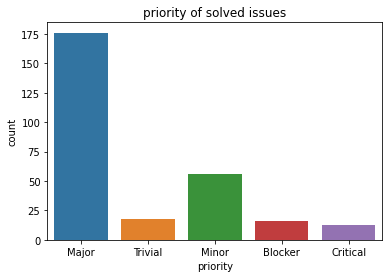

In [64]:
resolved_df = df[df['status'] == 'Resolved']
ax = sns.countplot(x="priority",  data=resolved_df).set_title('priority of solved issues')
plt.show()
#convert to features -> is_major

In [8]:
resolved_df = df[df['status'] == 'Resolved']

resolved_df.describe()
#few of them were solved

,vote_count,comment_count,description_length,summary_length,watch_count,days_in_current_status
count,279.000000,279.000000,274.000000,279.000000,279.000000,279.000000
mean,0.272401,6.670251,938.620438,52.827957,3.788530,685.949531
std,1.020117,7.600564,1405.278454,21.699198,2.215481,504.173463
min,0.000000,0.000000,39.000000,13.000000,1.000000,2.025288
25%,0.000000,3.000000,247.500000,38.000000,2.000000,323.186702
50%,0.000000,5.000000,538.000000,51.000000,3.000000,575.669745
75%,0.000000,7.500000,1112.500000,64.000000,5.000000,812.487994
max,9.000000,65.000000,17439.000000,186.000000,17.000000,1920.838996


<AxesSubplot:xlabel='vote_count', ylabel='count'>

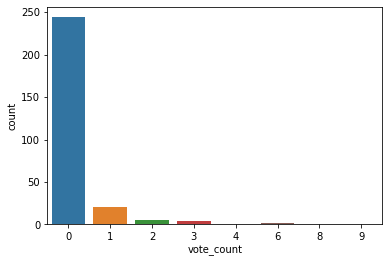

In [9]:
sns.countplot(x="vote_count",  data=resolved_df)
#convert to one hot-encoded feature -> has_votes

<AxesSubplot:xlabel='watch_count', ylabel='count'>

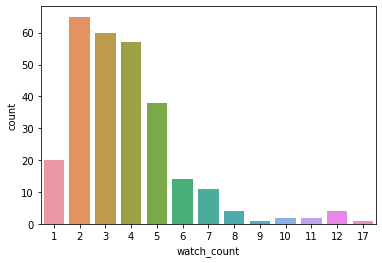

In [11]:
sns.countplot(x="watch_count",  data=resolved_df)

<AxesSubplot:xlabel='to_status', ylabel='count'>

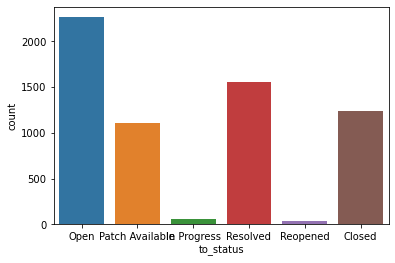

In [17]:
sns.countplot(x="to_status",  data=merged_df)
#one hot encoding? progress and reopened together

<AxesSubplot:xlabel='from_status', ylabel='count'>

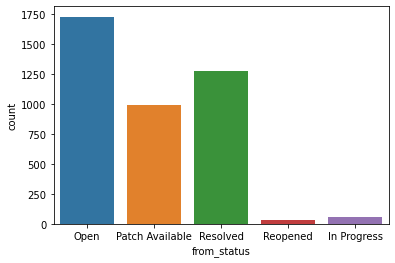

In [18]:
sns.countplot(x="from_status",  data=merged_df)
#one hot encoding? progress and reopened together

In [12]:
df_with_solutiondata = df[df["resolutiondate"].notnull()]
df_with_solutiondata

#1515 are thw numbers of unique key about the solved issues

#so there is a discrepancy between solved issues and issues with resolution date

,status,priority,updated,issue_type,reporter,created,resolutiondate,vote_count,project,assignee,comment_count,key,description_length,summary_length,watch_count,resolution,days_in_current_status
2,Resolved,Major,2018-04-24T06:34:58.782+0000,Improvement,jmukesh,2018-04-06T13:45:28.721+0000,2018-04-24T06:34:58.762+0000,0,AVRO,NaN,0,AVRO-2169,1062.0,75,1,Not A Bug,2.025288
3,Resolved,Major,2018-04-24T06:34:37.360+0000,Bug,jmukesh,2018-04-05T13:21:01.183+0000,2018-04-24T06:34:37.339+0000,0,AVRO,NaN,1,AVRO-2168,272.0,64,1,Not A Bug,2.025536
4,Resolved,Major,2018-04-24T06:34:15.849+0000,Bug,jmukesh,2018-04-04T16:39:43.364+0000,2018-04-24T06:34:15.829+0000,0,AVRO,NaN,0,AVRO-2167,674.0,53,1,Not A Bug,2.025785
5,Resolved,Major,2018-04-24T06:32:37.556+0000,Bug,jmukesh,2018-04-04T16:29:37.306+0000,2018-04-24T06:32:37.535+0000,0,AVRO,NaN,1,AVRO-2166,1043.0,39,2,Not A Bug,2.026923
14,Resolved,Trivial,2018-03-14T16:45:08.597+0000,Bug,maxenglander,2018-03-09T06:18:47.199+0000,2018-03-14T16:45:08.577+0000,0,AVRO,maxenglander,3,AVRO-2157,825.0,82,2,Fixed,42.601563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2161,Closed,Major,2009-07-14T22:50:08.305+0000,Test,sharadag,2009-04-11T10:54:25.016+0000,2009-04-15T05:27:21.612+0000,0,AVRO,sharadag,6,AVRO-5,50.0,49,0,Fixed,3207.348097
2162,Closed,Major,2009-07-14T22:50:08.238+0000,Bug,phunt,2009-04-10T23:20:38.998+0000,2009-04-14T22:12:34.962+0000,0,AVRO,phunt,2,AVRO-4,494.0,36,0,Fixed,3207.348098
2163,Closed,Critical,2009-07-14T22:50:08.150+0000,Bug,phunt,2009-04-10T20:14:54.370+0000,2009-04-10T23:31:56.052+0000,0,AVRO,cutting,4,AVRO-3,262.0,54,0,Fixed,3207.348099
2164,Closed,Major,2009-07-14T22:50:08.061+0000,Improvement,cutting,2009-04-09T22:34:55.599+0000,2009-06-02T19:04:10.508+0000,0,AVRO,cutting,7,AVRO-2,204.0,22,1,Fixed,3207.348100


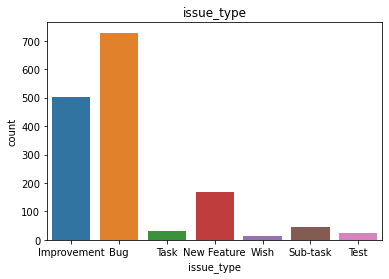

In [13]:
col = "issue_type"
ax = sns.countplot(x=col,  data=df_with_solutiondata).set_title(col)
#improvement and bug are the most present issue type
#wht if we aggregate all the rare features into one and use one hot encoded feature?

In [15]:
#version with null and not null resolution date column
merged_df = df.merge(df_transition,how="inner",on="key",suffixes=('', '_drop'))

#if we merge transitions with solved issues, we increase the number of available data for training
# merged_df = df_with_solutiondata.merge(df_transition,how="inner",on="key",suffixes=('', '_drop'))


merged_df.drop([col for col in merged_df.columns if 'drop' in col], axis=1, inplace=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6260 entries, 0 to 6259
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   status                  6260 non-null   object 
 1   priority                6260 non-null   object 
 2   updated                 6260 non-null   object 
 3   issue_type              6260 non-null   object 
 4   reporter                6260 non-null   object 
 5   created                 6260 non-null   object 
 6   resolutiondate          5412 non-null   object 
 7   vote_count              6260 non-null   int64  
 8   project                 6260 non-null   object 
 9   assignee                4977 non-null   object 
 10  comment_count           6260 non-null   int64  
 11  key                     6260 non-null   object 
 12  description_length      5974 non-null   float64
 13  summary_length          6260 non-null   int64  
 14  watch_count             6260 non-null   

In [69]:
merged_df["key"].nunique()
#to me this means we have transitions of the same issue which report the same end date. 
#The problem is that we can't have multiple rows with the same resolution date

1515

In [70]:
#we look for issues with multiple steps
merged_df["key"].value_counts()

AVRO-1614    12
AVRO-1551    10
AVRO-314     10
AVRO-152      8
AVRO-1660     7
             ..
AVRO-2107     2
AVRO-1510     2
AVRO-1361     2
AVRO-1244     2
AVRO-1565     2
Name: key, Length: 1515, dtype: int64

In [71]:
temp = merged_df[merged_df["key"] == "AVRO-1614"]
#this prove what I said before
temp["resolutiondate"].nunique()


1

In [19]:
#we create target to define how many hours,minutes and seconds were spent to find a solution to the problem
custom_df = merged_df
for index, row in merged_df.iterrows():
    
    t_current = datetime.datetime.strptime(row['when'], "%Y-%m-%dT%H:%M:%S.%f%z")
    #day of week
    custom_df.loc[index,'weekday']  = t_current.weekday()
    custom_df.loc[index,'week_of_year'] = t_current.isocalendar()[1]
    custom_df.loc[index,'day'] = t_current.day
    custom_df.loc[index,'month'] = t_current.month
    custom_df.loc[index,'year'] = t_current.year
    #t_spent_in_month = t_spent_in_hours/30    
    
    if( str(row['resolutiondate']) != 'nan'):
        t_created = datetime.datetime.strptime(row['created'], "%Y-%m-%dT%H:%M:%S.%f%z")
        t_solved = datetime.datetime.strptime(row['resolutiondate'], "%Y-%m-%dT%H:%M:%S.%f%z")
        sol_time_spent = t_solved - t_current
        time_passed_so_far = t_current - t_created

        t_passed_seconds = time_passed_so_far.total_seconds()
        t_spent_in_seconds = sol_time_spent.total_seconds()
        t_spent_in_minutes = t_spent_in_seconds/60    
        t_spent_in_hours = t_spent_in_minutes/60
        t_spent_in_days = t_spent_in_hours/24




        if(t_spent_in_seconds > 0):
            custom_df.loc[index,'sec_to_sol'] = t_spent_in_seconds
        else:
            #I noticed there are transitions in which the creation date is later than the solution date. I want to delete
            #those because it is useless
            custom_df.loc[index,'sec_to_sol'] = 0.5

        if t_passed_seconds > 0:
            custom_df.loc[index,'sec_passed_so_far'] = t_passed_seconds
        else:
            custom_df.loc[index,'sec_passed_so_far'] = 0
custom_df.info()

#i don't include zero because log of zero

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6260 entries, 0 to 6259
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   status                  6260 non-null   object 
 1   priority                6260 non-null   object 
 2   updated                 6260 non-null   object 
 3   issue_type              6260 non-null   object 
 4   reporter                6260 non-null   object 
 5   created                 6260 non-null   object 
 6   resolutiondate          5412 non-null   object 
 7   vote_count              6260 non-null   int64  
 8   project                 6260 non-null   object 
 9   assignee                4977 non-null   object 
 10  comment_count           6260 non-null   int64  
 11  key                     6260 non-null   object 
 12  description_length      5974 non-null   float64
 13  summary_length          6260 non-null   int64  
 14  watch_count             6260 non-null   

In [73]:
#we just keep rows whose time spent to solve is greater than zero, ie not nan
custom_df = custom_df[custom_df["sec_to_sol"].notnull()]

In [20]:
#we have a problem of right skewdeness
#in order to solve the problem, we apply log transformation to the target variable
custom_df["sec_to_sol"].agg(['skew', 'kurtosis']).transpose()

skew          9.085625
kurtosis    103.628933
Name: sec_to_sol, dtype: float64

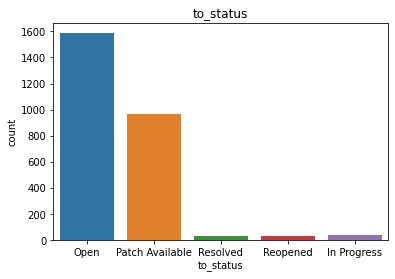

In [75]:
col = "to_status"
ax = sns.countplot(x=col,  data=custom_df).set_title(col)

In [23]:
# custom_df['weekday'] = custom_df['calendar_day'].apply(
#         lambda x: get_calender_day(x) )  
ax = sns.distplot(x='sec_to_sol',  data=custom_df)

TypeError: distplot() got an unexpected keyword argument 'data'

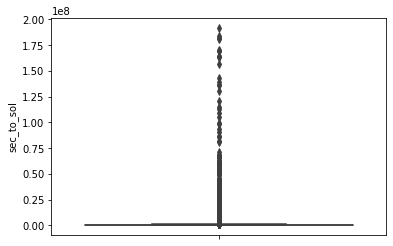

In [24]:
var = ["sec_to_sol"]#"min_to_sol","h_to_sol","day_to_sol"]
for v in var:
    ax = sns.boxplot(y=custom_df[v])
    plt.show()
    

C:\Users\gabri\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


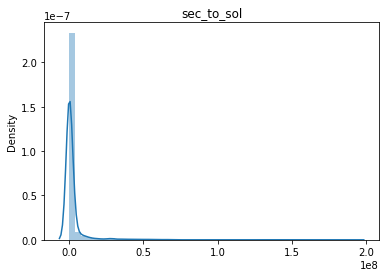

In [25]:
var = ["sec_to_sol"]#,"min_to_sol","h_to_sol","day_to_sol"]
for v in var:
    ax = sns.distplot(x= custom_df[v])
    plt.title(v)
    plt.show()
    

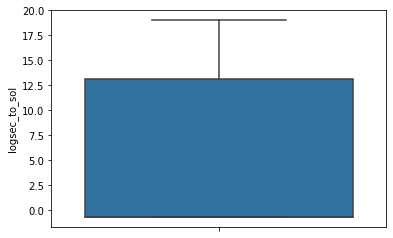

C:\Users\gabri\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


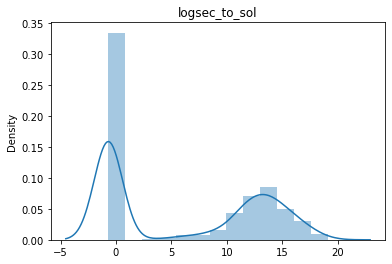

skew        0.215736
kurtosis   -1.763944
Name: logsec_to_sol, dtype: float64


In [26]:
#we apply log transform to get rid of the skewdness
var = ["sec_to_sol"]#,"min_to_sol","h_to_sol","day_to_sol"]
for v in var:
    custom_df['log'  + v] = np.log(custom_df[v])
    #boxplot
    ax = sns.boxplot(y=custom_df['log' + v])
    plt.show()
    
    ax = sns.distplot(x= custom_df['log' + v])
    plt.title('log' + v)
    plt.show()
    print(custom_df['log' + v].agg(['skew', 'kurtosis']).transpose())

In [80]:
#if we keep zeros, we don't have anymore a normal distriubtion in the target variables
#what if we create two models. One will predict whether the issue will be solved in a bunch of seconds or not

#we may drop whatever is below ~ 6,25 (outliers) in order to better model fitting later on 
#(we would not be able to predict forecast on the first e^6,25 = 8,63 minutes). Is it a big problem?

D:\anaconda\envs\myenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
D:\anaconda\envs\myenv\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
D:\anaconda\envs\myenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
D:\anaconda\envs\myenv\lib\site-packages\sea

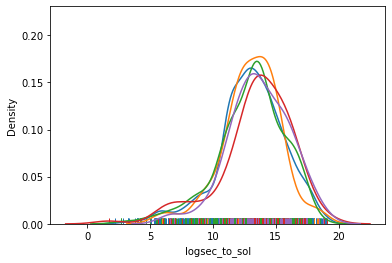

D:\anaconda\envs\myenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
D:\anaconda\envs\myenv\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
D:\anaconda\envs\myenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
D:\anaconda\envs\myenv\lib\site-packages\sea

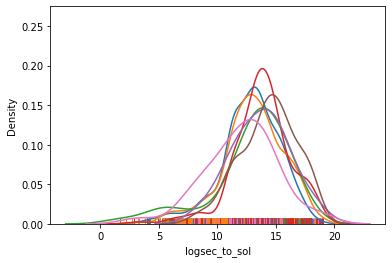

In [81]:
#i would delete everything below 
#for both the features, each categorical value share kind of the same distribution
[sns.distplot(custom_df[custom_df["priority"] == el]["logsec_to_sol"], hist=False, rug=True) for el in custom_df["priority"].unique()]
plt.show()
[sns.distplot(custom_df[custom_df["issue_type"] == el]["logsec_to_sol"], hist=False, rug=True) for el in custom_df["issue_type"].unique()]
plt.show()



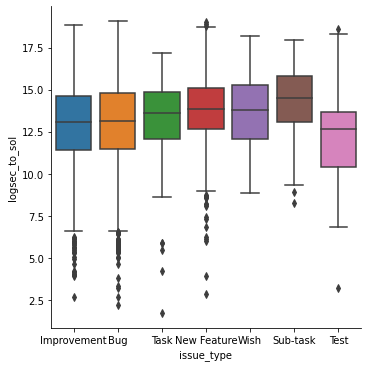

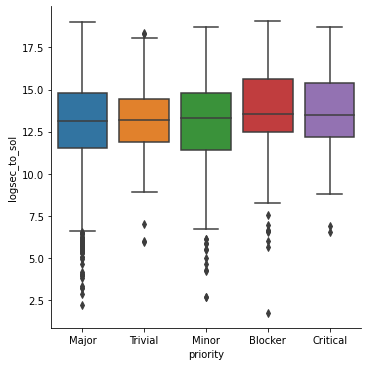

In [82]:
#box plot overallqual/saleprice
var = ["issue_type", "priority"]
for v  in var:
    sns.catplot(x=v, y="logsec_to_sol", kind="box", data=custom_df)
    plt.show()

In [83]:
# the idea of cutting belows ~6,25 persit since Improvement and Bug are the main issue type in the dataset

In [84]:
# custom_df["sec_to_sol"].describe()

# d = custom_df[custom_df["sec_to_sol"] > 0]


# d["log_h_to_sol"] = np.log(d['h_to_sol'])
# print(d["sec_to_sol"].describe())
# ax = sns.distplot(x=d["log_h_to_sol"] )
# plt.title("log_h_to_sol")
# plt.show()


# custom_df["sec_to_sol"]
custom_df.describe()

,vote_count,comment_count,description_length,summary_length,watch_count,days_in_current_status,days_in_from_status,days_since_open,weekday,week_of_year,day,month,year,sec_to_sol,sec_passed_so_far,logsec_to_sol
count,2661.000000,2661.000000,2543.000000,2661.000000,2661.000000,2661.000000,1146.000000,1146.000000,2661.000000,2661.000000,2661.000000,2661.000000,2661.000000,2.661000e+03,2.661000e+03,2661.000000
mean,0.173995,7.458098,622.383799,51.671552,2.355881,2031.939585,42.731342,54.796857,2.465239,25.327696,15.300263,6.234123,2011.951898,5.464242e+06,2.038962e+06,13.071676
std,0.798598,8.665561,1027.907093,20.526848,2.748341,935.190536,174.495938,195.984333,1.731837,15.845070,8.519175,3.609571,2.480590,1.692406e+07,1.135432e+07,2.675498
min,0.000000,0.000000,15.000000,8.000000,0.000000,2.025288,0.000031,0.000120,0.000000,1.000000,1.000000,1.000000,2009.000000,5.558000e+00,0.000000e+00,1.715238
25%,0.000000,3.000000,156.000000,37.000000,0.000000,1371.454926,0.003143,0.004899,1.000000,11.000000,8.000000,3.000000,2010.000000,1.007204e+05,0.000000e+00,11.520103
50%,0.000000,5.000000,305.000000,49.000000,2.000000,2262.267311,0.156664,0.739200,2.000000,25.000000,15.000000,6.000000,2011.000000,5.593877e+05,0.000000e+00,13.234598
75%,0.000000,9.000000,677.000000,63.000000,4.000000,2946.597666,7.832119,13.947131,4.000000,40.000000,22.000000,9.000000,2014.000000,2.850684e+06,9.395185e+03,14.863070
max,9.000000,84.000000,17439.000000,186.000000,33.000000,3207.348102,2175.533870,2175.533870,6.000000,53.000000,31.000000,12.000000,2018.000000,1.919659e+08,1.879661e+08,19.072828


In [85]:
#the higher vote_count and watch_count, the less variance of time spent to solve 

In [86]:
#for each key of the resolved issues, we keep count of the previous transictions made so far
issue_keys = custom_df["key"].unique()
issue_keys_dict = { key : 0 for key in issue_keys }

# #we sort rows by their time of creation
sorted_df = custom_df.sort_values(by=['when'])
for index, row in sorted_df.iterrows():
    #we create new feature
    custom_df.loc[index,'transictions_so_far'] = issue_keys_dict[row['key']]
    #we keep count of the # of transictions so far
    issue_keys_dict[row['key']] += 1
    

D:\anaconda\envs\myenv\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
D:\anaconda\envs\myenv\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [87]:
custom_df.isna().sum()

#explaining why nans for columns

#  -assignee: we don't care
#  -from_status: the issue was open, so it was inexistent before (you can look to the # of nans which equals the # of keys)
#  -days_in_from_status: idem as above 
#  -days_since_open: days_since_open

#what to do:
# --assignee: delete
# --from_status: replace with inexistent
# --days_since_open: delete(?) since we alredy have the coumn sec_passed_so_far 
# --days_in_from_status:repplace with 0
custom_df.loc[custom_df['from_status'].isna(),['from_status']] = 'Inexistent'
custom_df.loc[custom_df['days_since_open'].isna(),['days_since_open']] = 0
custom_df.loc[custom_df['days_in_from_status'].isna(),['days_in_from_status']] = 0
custom_df.loc[custom_df['description_length'].isna(),['description_length']] = custom_df['description_length'].mean()

In [88]:
custom_df.groupby(['key'])['assignee'].nunique().describe()
#assignee is useless


count    1515.000000
mean        0.852145
std         0.355073
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: assignee, dtype: float64

In [89]:
custom_df['from_status'].unique()

array(['Inexistent', 'Open', 'Resolved', 'Patch Available', 'In Progress',
       'Reopened'], dtype=object)

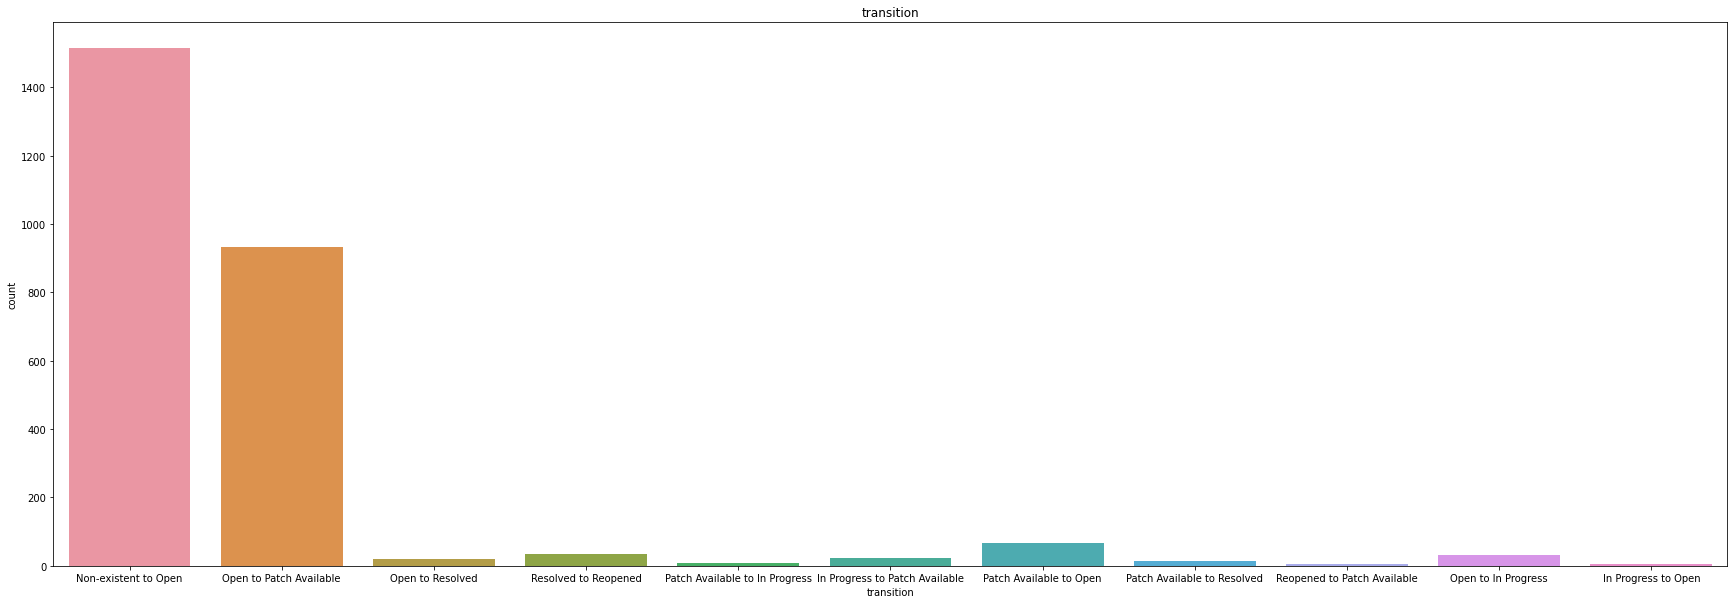

In [90]:
col = 'transition'
fig, ax = plt.subplots(figsize=(30,10))
x = sns.countplot(x=col,  data=custom_df).set_title(col)

#in the plot is not listed how many transitions there were from inexistent to open


In [91]:
print('from_status',custom_df['from_status'].value_counts())
print('------------------')
print('to_status', custom_df['to_status'].value_counts())
#there is too much unbalance between the categorical values. I will convert all the column whose count is less than 200 to RARE

from_status Inexistent         1515
Open                987
Patch Available      90
Resolved             35
In Progress          28
Reopened              6
Name: from_status, dtype: int64
------------------
to_status Open               1585
Patch Available     964
In Progress          42
Reopened             35
Resolved             35
Name: to_status, dtype: int64


In [92]:
#feature to capture how many issues the assigned user solved so far 
problem_solvers = custom_df[custom_df['to_status'] == 'Resolved']['assignee'].value_counts().reset_index()
problem_solvers= problem_solvers.rename(columns={"index": 'assignee', 'assignee': "issue_solved_by_assignee"})
custom_df = pd.merge(custom_df, problem_solvers,  on=['assignee'])


In [93]:
to_modify = ['Patch Available', 'Resolved','In Progress','Reopened']
custom_df.loc[custom_df['from_status'].isin(to_modify),['from_status'] ] = 'RARE'


In [94]:
to_modify = ['Resolved','In Progress','Reopened']
custom_df.loc[custom_df['to_status'].isin(to_modify),['to_status'] ] = 'RARE'
df_day_count.loc[df_day_count['status'].isin(to_modify),['status'] ] = 'RARE'

In [95]:
df_day_count['status'].value_counts()

RARE               9906
Open               3302
Closed             3302
Patch Available    3302
Name: status, dtype: int64

In [96]:
def get_calender_day(x):
    o = datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%f%z")
    
    return str(o.day) + "-" + str(o.month) + "-" + str(o.year)
    
#I convert both the Iso date into string of the following format (dd-mm-yyyy) in order to 
custom_df['calendar_day'] = custom_df['when'].apply(
        lambda x: get_calender_day(x) )  

df_day_count['calendar_day'] = df_day_count['day'].apply(
        lambda x: get_calender_day(x) )  


#we merge the previous custom df made so far  and the day_count df
custom_df = pd.merge(custom_df, df_day_count,  how='left', left_on=['calendar_day','to_status'], right_on = ['calendar_day','status'],suffixes=('', '_drop'))
#we drop every duplicate from the merge process
custom_df.drop([col for col in custom_df.columns if 'drop' in col], axis=1, inplace=True)
#we if there are to_status columns which are empty
assert(custom_df['to_status'].isna().sum() == 0)

In [97]:
#create feature for day,month,year
# for index, row in custom_df.iterrows():
#     #we create new feature
#     o = datetime.datetime.strptime(row['when'],"%Y-%m-%dT%H:%M:%S.%f%z")
#     #we keep count of the # of transictions so far
#     custom_df.loc[index,'day'] = o.day
#     custom_df.loc[index,'month'] = o.month
#     custom_df.loc[index,'year'] = o.year

In [98]:
# number of issue of the same per month and year
custom_df['count_month_of_year'] = custom_df.groupby(['year','month'])['count'].transform('sum')
custom_df['count_year'] =  custom_df.groupby(['year'])['count'].transform('sum')

In [99]:
custom_df.isna().sum()


status                      0
priority                    0
updated                     0
issue_type                  0
reporter                    0
created                     0
resolutiondate              0
vote_count                  0
project                     0
assignee                    0
comment_count               0
key                         0
description_length          0
summary_length              0
watch_count                 0
resolution                  0
days_in_current_status      0
from_status                 0
when                        0
days_in_from_status         0
who                         0
to_status                   0
days_since_open             0
transition                  0
weekday                     0
week_of_year                0
day                         0
month                       0
year                        0
sec_to_sol                  0
sec_passed_so_far           0
logsec_to_sol               0
transictions_so_far         0
issue_solv

In [100]:
#we remove 'year', 'day_in_from_status', 'from_status'

#we create new freature for defining how many people working on a specific issue 
group_assignee = custom_df.groupby(['key'])['assignee'].unique().reset_index()
group_reporter = custom_df.groupby(['key'])['reporter'].unique().reset_index()
group_who = custom_df.groupby(['key'])['who'].unique().reset_index()


merge_groups = pd.merge(group_assignee, group_reporter,  on='key')
merge_groups = pd.merge(merge_groups, group_who,  on='key')

for index, row in merge_groups.iterrows():
    teamList = list(row['assignee'])
    
    for el in row['reporter']:
        if(el not in teamList):
            teamList.append(el)
            
    for el in row['who']:
        if(el not in teamList):
            teamList.append(el)
            
    merge_groups.loc[index,'team_count'] = len(teamList)
    

merge_groups['team_count'].describe()

count    552.000000
mean       1.472826
std        0.574081
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        5.000000
Name: team_count, dtype: float64

In [101]:
custom_df = pd.merge(custom_df, merge_groups,  on='key' ,suffixes=('', '_drop'))
custom_df.drop([col for col in custom_df.columns if 'drop' in col], axis=1, inplace=True)
custom_df

,status,priority,updated,issue_type,reporter,created,resolutiondate,vote_count,project,assignee,...,sec_to_sol,sec_passed_so_far,logsec_to_sol,transictions_so_far,issue_solved_by_assignee,calendar_day,count,count_month_of_year,count_year,team_count
0,Resolved,Major,2018-02-22T00:52:52.033+0000,Improvement,elmendavies,2018-02-12T16:12:41.548+0000,2018-02-22T00:52:52.017+0000,0,AVRO,cutting,...,8.088105e+05,0.000,13.603320,0.0,6,12-2-2018,529,1011,1644,2.0
1,Resolved,Major,2018-02-22T00:52:52.033+0000,Improvement,elmendavies,2018-02-12T16:12:41.548+0000,2018-02-22T00:52:52.017+0000,0,AVRO,cutting,...,7.103487e+05,98461.746,13.473511,1.0,6,13-2-2018,104,1011,1644,2.0
2,Resolved,Major,2018-02-23T00:10:37.233+0000,Improvement,kdrakon,2018-01-18T02:49:13.924+0000,2018-02-22T19:26:30.813+0000,0,AVRO,cutting,...,3.083837e+06,0.000,14.941685,0.0,6,18-1-2018,523,523,1644,2.0
3,Resolved,Major,2018-02-27T22:06:15.650+0000,Bug,radai,2017-05-17T01:27:34.188+0000,2018-02-27T22:06:15.627+0000,0,AVRO,cutting,...,2.478472e+07,0.000,17.025738,0.0,6,17-5-2017,484,484,4030,2.0
4,Resolved,Major,2018-02-27T22:06:15.650+0000,Bug,radai,2017-05-17T01:27:34.188+0000,2018-02-27T22:06:15.627+0000,0,AVRO,cutting,...,2.161830e+07,3166420.554,16.889051,1.0,6,22-6-2017,101,807,4030,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122,Closed,Major,2010-09-08T21:07:43.829+0000,Bug,neopallium,2010-04-03T13:45:43.028+0000,2010-08-25T19:24:00.389+0000,0,AVRO,neopallium,...,1.236892e+07,92979.944,16.330697,1.0,1,4-4-2010,0,1097,18730,3.0
1123,Closed,Major,2010-09-08T21:07:43.829+0000,Bug,neopallium,2010-04-03T13:45:43.028+0000,2010-08-25T19:24:00.389+0000,0,AVRO,neopallium,...,1.236892e+07,92979.944,16.330697,1.0,1,4-4-2010,2,1097,18730,3.0
1124,Closed,Major,2010-09-08T21:07:43.829+0000,Bug,neopallium,2010-04-03T13:45:43.028+0000,2010-08-25T19:24:00.389+0000,0,AVRO,neopallium,...,1.236803e+07,93869.582,16.330625,2.0,1,4-4-2010,7,1097,18730,3.0
1125,Closed,Major,2010-09-08T21:07:43.829+0000,Bug,neopallium,2010-04-03T13:45:43.028+0000,2010-08-25T19:24:00.389+0000,0,AVRO,neopallium,...,1.236803e+07,93869.582,16.330625,2.0,1,4-4-2010,0,1097,18730,3.0


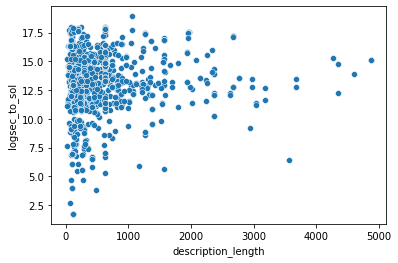

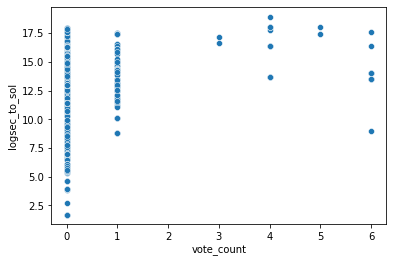

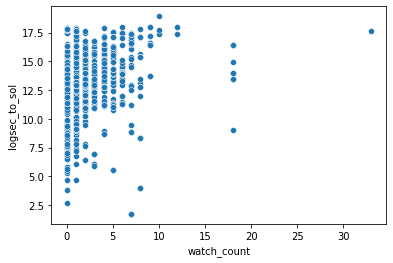

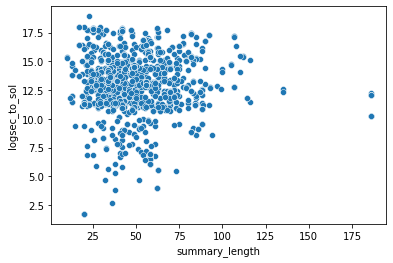

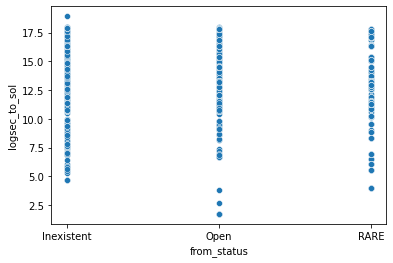

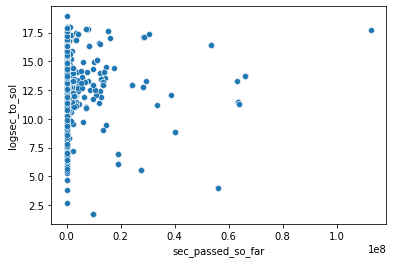

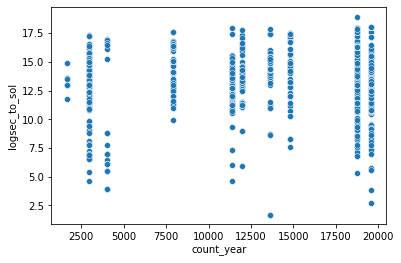

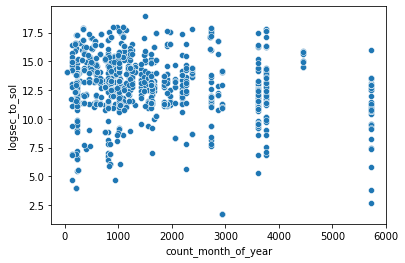

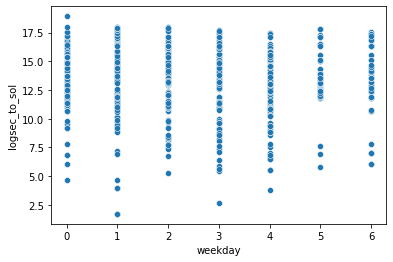

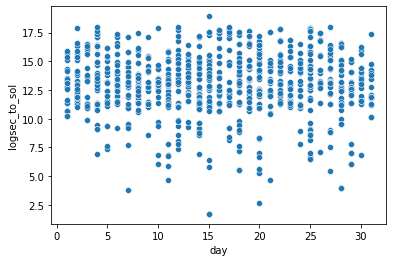

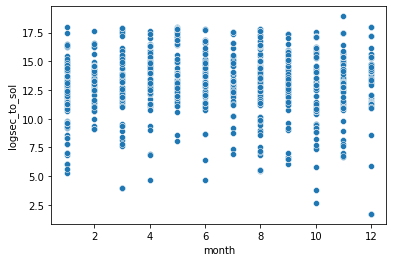

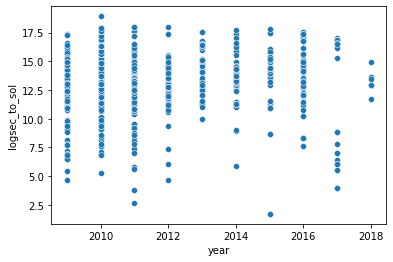

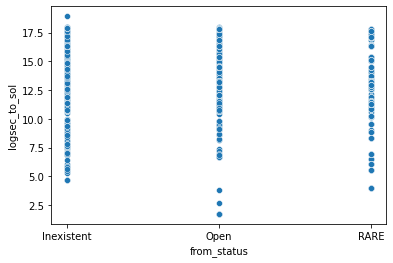

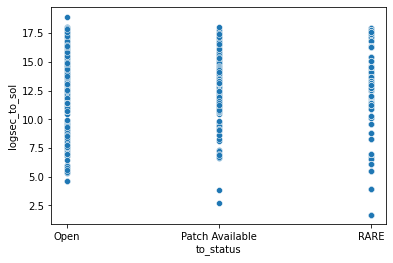

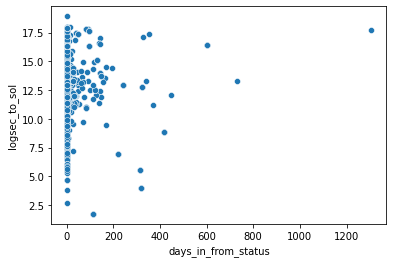

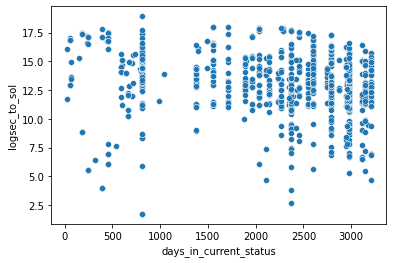

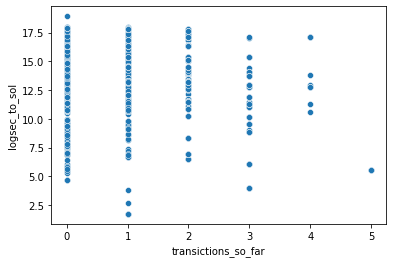

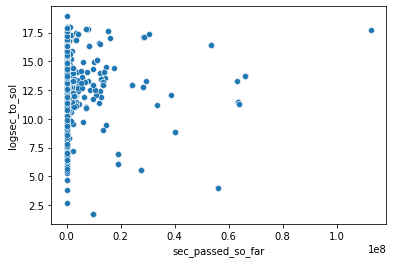

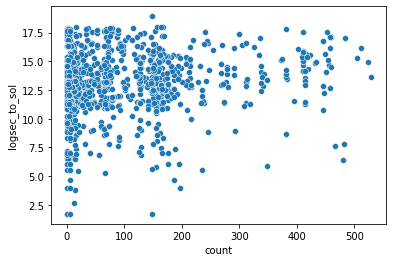

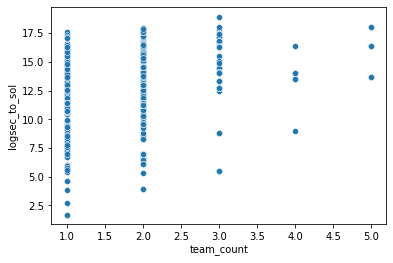

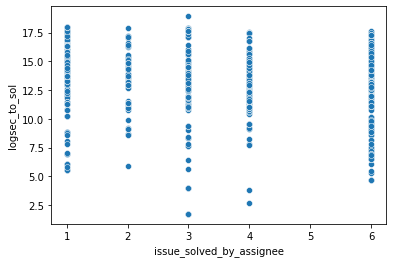

In [102]:
#print outliers for pp plot
var = ["description_length","vote_count","watch_count","summary_length","from_status", "sec_passed_so_far","count_year",\
      'count_month_of_year','weekday','day','month','year','from_status','to_status','days_in_from_status','days_in_current_status',\
       'transictions_so_far','sec_passed_so_far','count',\
       'team_count', 'issue_solved_by_assignee'   
      ]
for v in var:
    
    sns.scatterplot(data=custom_df, x=v, y="logsec_to_sol")
    plt.show()
#description_length,watch_count and summary_length show outliers we may delete from the df

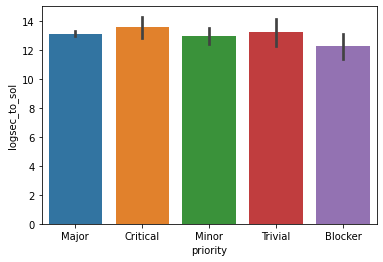

In [49]:
#even if there could preferences to label encode, the time spent for solving the different priorities does not change
ax = sns.barplot(x="priority", y="logsec_to_sol", data=custom_df)


In [50]:
#label encoding of categorical features
custom_df.info()

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
cols = ['priority','from_status','to_status','issue_type','status','who','assignee','resolution']
for col in cols:
    custom_df[col] = le.fit_transform(custom_df[col])



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1127 entries, 0 to 1126
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   status                    1127 non-null   object 
 1   priority                  1127 non-null   object 
 2   updated                   1127 non-null   object 
 3   issue_type                1127 non-null   object 
 4   reporter                  1127 non-null   object 
 5   created                   1127 non-null   object 
 6   resolutiondate            1127 non-null   object 
 7   vote_count                1127 non-null   int64  
 8   project                   1127 non-null   object 
 9   assignee                  1127 non-null   object 
 10  comment_count             1127 non-null   int64  
 11  key                       1127 non-null   object 
 12  description_length        1127 non-null   float64
 13  summary_length            1127 non-null   int64  
 14  watch_co

In [51]:
#feature selection 

X_train=custom_df.drop(['year','logsec_to_sol','key','project','sec_to_sol','status','when',\
                       'updated','calendar_day','transition','who','created','reporter','updated',\
                       'resolutiondate'],axis=1)
y_train=custom_df[['logsec_to_sol']]
col_names = X_train.columns

In [52]:
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train, y_train)

X_train_st= scaler.transform(X_train)



reg = LassoCV()
reg.fit(X_train_st, y_train)

print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_train_st, y_train))
coef = pd.Series(reg.coef_, index = col_names)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


D:\anaconda\envs\myenv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
D:\anaconda\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.061430895135345, tolerance: 0.6745383367269312
  tol, rng, random, positive)
D:\anaconda\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.3753740544671, tolerance: 0.6745383367269312
  tol, rng, random, positive)
D:\anaconda\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of

Best alpha using built-in LassoCV: 0.394301
Best score using built-in LassoCV: 0.044426
Lasso picked 3 variables and eliminated the other 22 variables


In [53]:
custom_df.describe()

,status,priority,issue_type,vote_count,assignee,comment_count,description_length,summary_length,watch_count,resolution,...,year,sec_to_sol,sec_passed_so_far,logsec_to_sol,transictions_so_far,issue_solved_by_assignee,count,count_month_of_year,count_year,team_count
count,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,...,1127.000000,1.127000e+03,1.127000e+03,1127.000000,1127.00000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000
mean,0.101154,1.973381,0.887311,0.167702,6.340728,8.303461,550.161712,50.623780,2.214729,1.050577,...,2011.535049,4.592255e+06,2.700067e+06,13.046472,0.73913,4.277728,94.639752,1741.629104,13297.755102,1.629104
std,0.301666,0.657787,1.066480,0.729549,5.521728,9.956933,663.114923,22.576817,2.936576,0.440125,...,2.320341,1.186104e+07,9.483157e+06,2.596470,0.91237,1.891382,113.450452,1466.621864,6273.341270,0.698238
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,10.000000,0.000000,0.000000,...,2009.000000,5.558000e+00,0.000000e+00,1.715238,0.00000,1.000000,0.000000,33.000000,1644.000000,1.000000
25%,0.000000,2.000000,0.000000,0.000000,2.000000,3.000000,156.000000,36.000000,0.000000,1.000000,...,2010.000000,9.956681e+04,0.000000e+00,11.508584,0.00000,3.000000,9.000000,742.000000,7905.000000,1.000000
50%,0.000000,2.000000,1.000000,0.000000,2.000000,5.000000,301.000000,47.000000,1.000000,1.000000,...,2011.000000,5.157896e+05,1.038010e+02,13.153454,1.00000,4.000000,50.000000,1189.000000,14826.000000,2.000000
75%,0.000000,2.000000,1.000000,0.000000,13.000000,10.000000,622.383799,61.000000,4.000000,1.000000,...,2013.000000,2.256884e+06,3.544776e+05,14.629494,1.00000,6.000000,152.500000,2706.000000,18730.000000,2.000000
max,1.000000,4.000000,6.000000,6.000000,15.000000,77.000000,4873.000000,186.000000,33.000000,4.000000,...,2018.000000,1.646902e+08,1.127743e+08,18.919577,5.00000,6.000000,529.000000,5723.000000,19578.000000,5.000000


In [54]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score,mean_squared_error,mean_absolute_error,mean_squared_log_error
from sklearn_pandas import DataFrameMapper

kf =KFold(n_splits=5, shuffle=True, random_state=42)

cnt = 1
# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(X_train_st, y_train):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1
    
def rmse(score):
    rmse = np.sqrt(-score)
    print(f'rmse= {"{:.2f}".format(rmse)}')
    
    

Fold:1, Train set: 901, Test set:226
Fold:2, Train set: 901, Test set:226
Fold:3, Train set: 902, Test set:225
Fold:4, Train set: 902, Test set:225
Fold:5, Train set: 902, Test set:225


In [358]:
score = cross_val_score(LinearRegression(), X_train_st, y_train, cv= kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold: {score}')
rmse(score.mean())

Scores for each fold: [-5.87482749 -4.85905831 -4.98589501 -6.91954094 -5.92060057]
rmse= 2.39


In [359]:
custom_df.corr()

,status,priority,issue_type,vote_count,assignee,comment_count,description_length,summary_length,watch_count,resolution,...,year,sec_to_sol,sec_passed_so_far,logsec_to_sol,transictions_so_far,issue_solved_by_assignee,count,count_month_of_year,count_year,team_count
status,1.000000,0.027008,-0.113603,0.027771,0.127510,0.063985,0.186467,0.204059,0.325340,-0.025189,...,0.653423,0.234286,0.201030,0.091135,0.215350,-0.260969,0.296890,-0.099105,-0.121571,0.195140
priority,0.027008,1.000000,0.062817,0.085187,-0.075745,-0.042970,-0.110080,-0.010482,-0.037957,-0.007616,...,-0.038373,0.014286,0.013364,0.039372,0.028374,0.035929,-0.019289,0.012881,-0.048482,0.079033
issue_type,-0.113603,0.062817,1.000000,0.136172,-0.002523,0.186131,-0.128555,-0.257816,0.097910,0.106756,...,-0.062823,0.125376,0.117792,0.117823,-0.023850,-0.070325,0.004039,0.077199,0.076814,-0.047829
vote_count,0.027771,0.085187,0.136172,1.000000,0.047312,0.664435,-0.026847,-0.156684,0.595866,-0.026439,...,0.115879,0.217611,0.300521,0.140963,0.112483,-0.145130,-0.030065,-0.068806,-0.001803,0.429056
assignee,0.127510,-0.075745,-0.002523,0.047312,1.000000,0.067076,0.095161,0.109257,0.178143,0.052834,...,0.298929,-0.033921,0.060034,-0.021316,0.090112,-0.506109,0.169418,0.173676,0.159362,-0.034454
comment_count,0.063985,-0.042970,0.186131,0.664435,0.067076,1.000000,0.057362,-0.148832,0.692867,-0.021542,...,0.247439,0.119753,0.362235,0.162712,0.221156,-0.138456,0.007062,-0.131239,-0.057681,0.441328
description_length,0.186467,-0.110080,-0.128555,-0.026847,0.095161,0.057362,1.000000,0.311557,0.049425,0.205340,...,0.161813,0.049221,0.031018,0.076083,0.091016,-0.016983,0.069067,0.007093,0.078072,0.260042
summary_length,0.204059,-0.010482,-0.257816,-0.156684,0.109257,-0.148832,0.311557,1.000000,-0.068156,0.104163,...,0.119042,-0.049285,-0.062027,-0.001732,0.070424,-0.070177,0.038544,-0.006095,0.000113,0.120040
watch_count,0.325340,-0.037957,0.097910,0.595866,0.178143,0.692867,0.049425,-0.068156,1.000000,-0.004287,...,0.601444,0.236750,0.349299,0.209040,0.218153,-0.220052,0.207244,-0.147818,-0.115331,0.377583
resolution,-0.025189,-0.007616,0.106756,-0.026439,0.052834,-0.021542,0.205340,0.104163,-0.004287,1.000000,...,-0.004781,0.119377,0.071168,0.070438,0.066061,-0.111839,0.005399,0.018541,0.058334,0.139123


<AxesSubplot:>

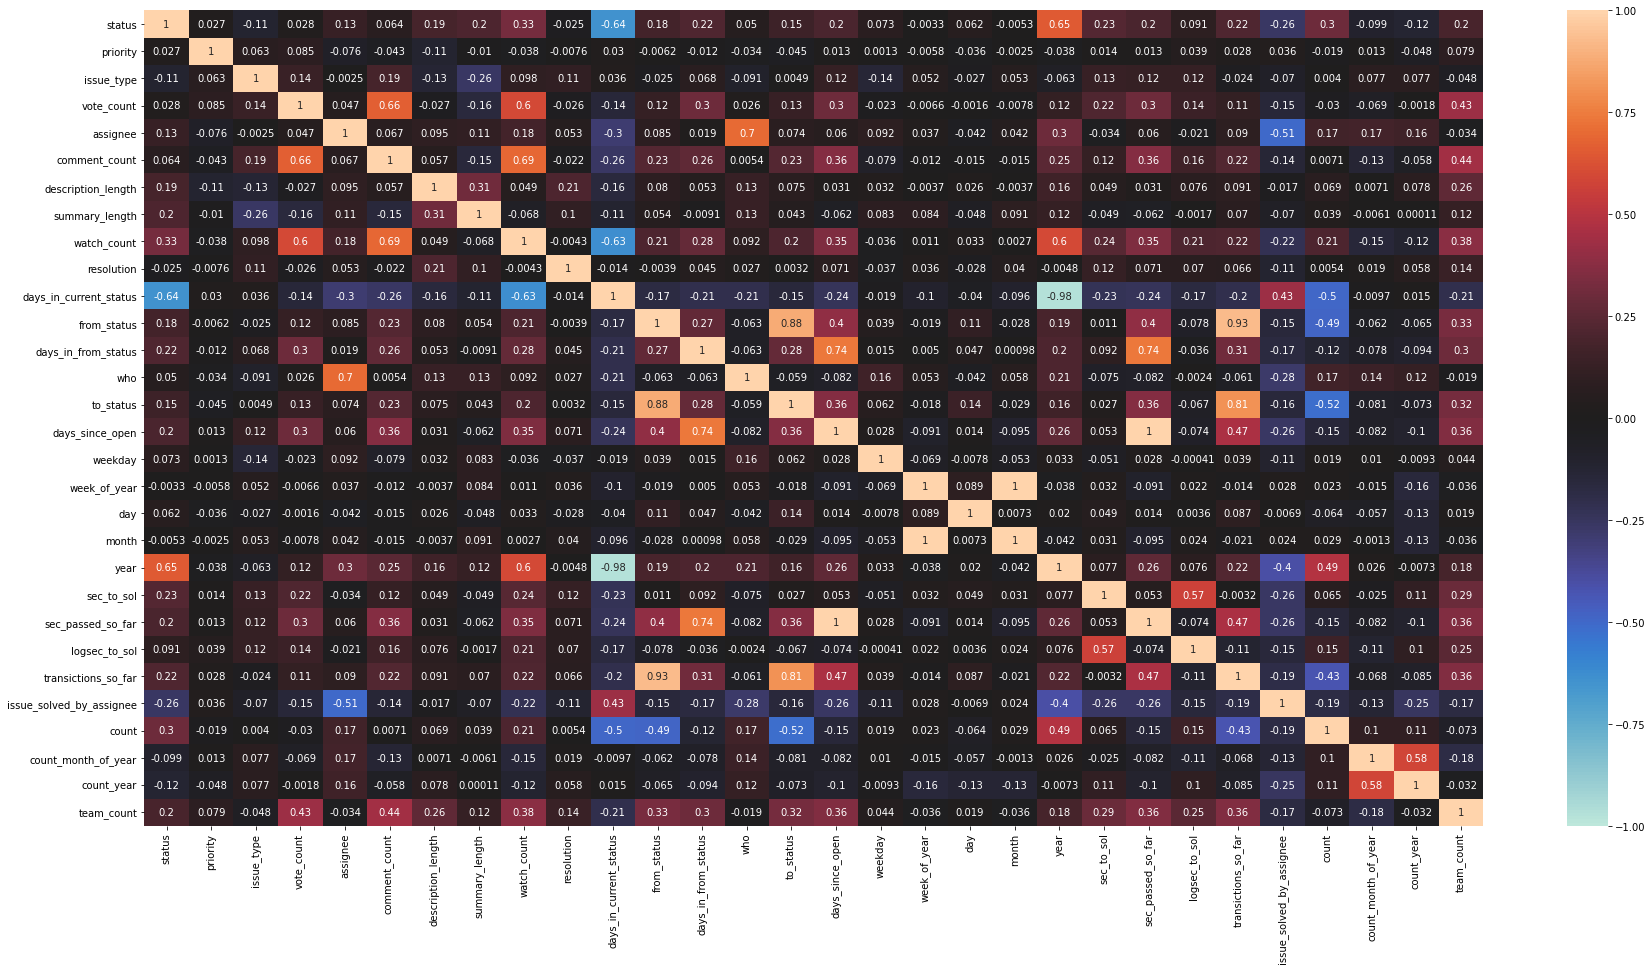

In [360]:
#correlation 
corrmat = custom_df.corr()
f, ax = plt.subplots(figsize=(30, 15))
sns.heatmap(custom_df.corr(), annot = True, vmin=-1, vmax=1, center= 0)

#not so much correlation. Maybe only just watch count and comment count

In [361]:
#I would like to do the same thing for the project. But in this case we only have one element
custom_df["project"].value_counts()

AVRO    1127
Name: project, dtype: int64

In [583]:
custom_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1127 entries, 0 to 1126
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   status                    1127 non-null   int32  
 1   priority                  1127 non-null   int32  
 2   updated                   1127 non-null   object 
 3   issue_type                1127 non-null   int32  
 4   reporter                  1127 non-null   object 
 5   created                   1127 non-null   object 
 6   resolutiondate            1127 non-null   object 
 7   vote_count                1127 non-null   int64  
 8   project                   1127 non-null   object 
 9   assignee                  1127 non-null   int32  
 10  comment_count             1127 non-null   int64  
 11  key                       1127 non-null   object 
 12  description_length        1127 non-null   float64
 13  summary_length            1127 non-null   int64  
 14  watch_co

In [160]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

#feature selection with lasso regressor
feature_sel_model = SelectFromModel(Lasso(alpha=0.005, random_state=0)) # remember to set the seed, the random state in this function
feature_sel_model.fit(X_train, y_train)

selected_feat = X_train.columns[(feature_sel_model.get_support())]

# let's print some stats
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format( \
    np.sum(feature_sel_model.estimator_.coef_ == 0)))


total features: 25
selected features: 23
features with coefficients shrank to zero: 1


In [585]:
selected_feat

Index(['priority', 'issue_type', 'vote_count', 'assignee', 'comment_count',
       'description_length', 'summary_length', 'watch_count',
       'days_in_current_status', 'from_status', 'days_in_from_status',
       'to_status', 'days_since_open', 'weekday', 'day', 'month',
       'transictions_so_far', 'issue_solved_by_assignee', 'count',
       'count_month_of_year', 'count_year', 'team_count'],
      dtype='object')

In [823]:
custom_df.columns

Index(['status', 'priority', 'updated', 'issue_type', 'reporter', 'created',
       'resolutiondate', 'vote_count', 'project', 'assignee', 'comment_count',
       'key', 'description_length', 'summary_length', 'watch_count',
       'resolution', 'days_in_current_status', 'from_status', 'when',
       'days_in_from_status', 'who', 'to_status', 'days_since_open',
       'transition', 'weekday', 'week_of_year', 'day', 'month', 'year',
       'sec_to_sol', 'sec_passed_so_far', 'logsec_to_sol',
       'transictions_so_far', 'issue_solved_by_assignee', 'calendar_day',
       'count', 'count_month_of_year', 'count_year', 'team_count'],
      dtype='object')

In [784]:
X_train.columns

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

D:\anaconda\envs\myenv\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


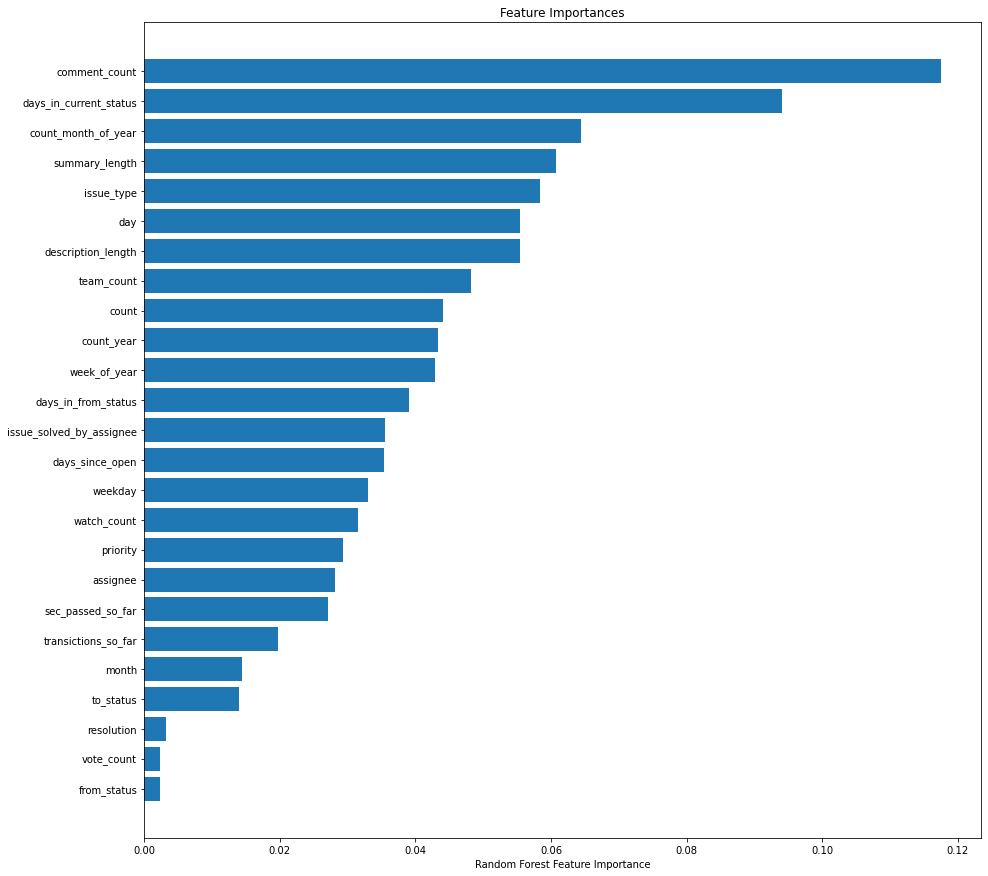

In [161]:
from sklearn.ensemble import RandomForestRegressor
#feature importance with random forest regressor

model = RandomForestRegressor()
# fit the model
model.fit(X_train_st, y_train)

importances = model.feature_importances_
idxs = np.argsort(importances)
plt.figure(figsize = (15,15))
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [col_names[i] for i in idxs])
plt.xlabel('Random Forest Feature Importance')
plt.show()

In [162]:
#variance thresholding
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0)
sel.fit(X_train)  # fit finds the features with zero variance



VarianceThreshold(threshold=0)

C:\Users\gabri\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\gabri\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[21:28:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


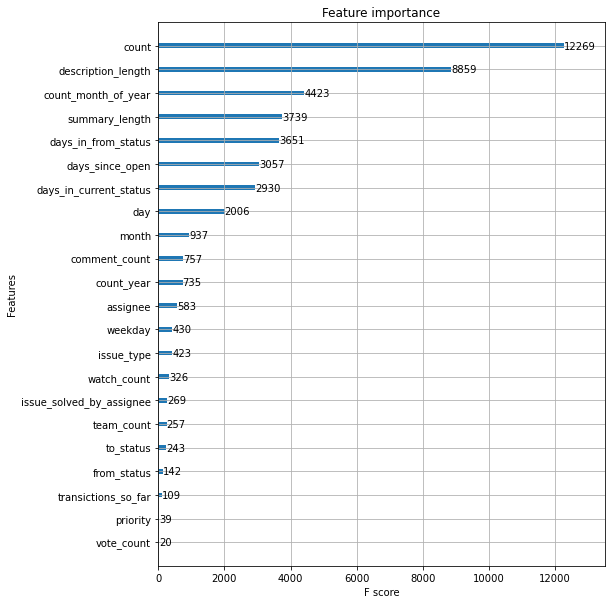

In [589]:
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# plot feature importance
plot_importance(model)
pyplot.show()

In [590]:
for i,c in enumerate(col_names):
    print(i,c)

0 priority
1 issue_type
2 vote_count
3 assignee
4 comment_count
5 description_length
6 summary_length
7 watch_count
8 days_in_current_status
9 from_status
10 days_in_from_status
11 to_status
12 days_since_open
13 weekday
14 day
15 month
16 sec_passed_so_far
17 transictions_so_far
18 issue_solved_by_assignee
19 count
20 count_month_of_year
21 count_year
22 team_count


In [622]:
columns_to_keep = ['priority', 'issue_type', 'vote_count', 'assignee', 'comment_count',
       'description_length', 'summary_length', 'watch_count',
       'days_in_current_status', 'from_status', 'days_in_from_status',
       'to_status', 'days_since_open', 'weekday', 'day', 'month',
       'transictions_so_far', 'issue_solved_by_assignee', 'count',
       'count_month_of_year', 'count_year', 'team_count']

Text(0.5, 1.0, 'Feature importance using Lasso Model')

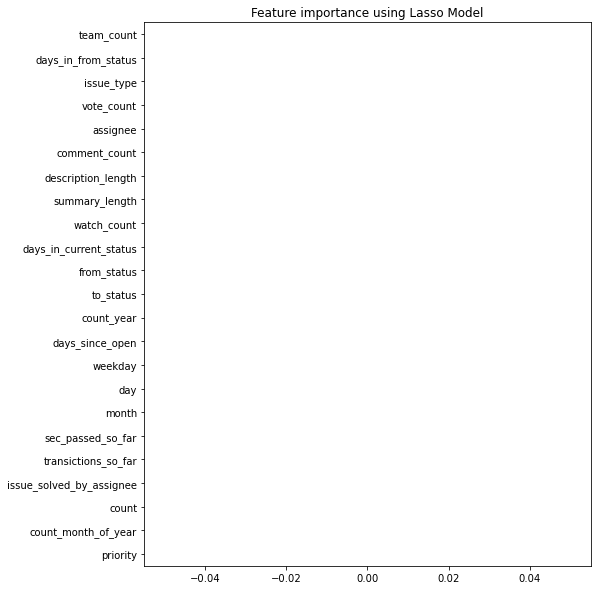

In [623]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

Index(['priority', 'issue_type', 'vote_count', 'assignee', 'comment_count',
       'description_length', 'summary_length', 'watch_count', 'resolution',
       'days_in_current_status', 'from_status', 'days_in_from_status',
       'to_status', 'days_since_open', 'weekday', 'week_of_year', 'day',
       'month', 'sec_passed_so_far', 'transictions_so_far',
       'issue_solved_by_assignee', 'count', 'count_month_of_year',
       'count_year', 'team_count'],
      dtype='object')
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ...........

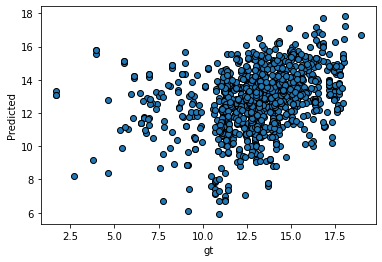

2.5700391634848208

In [383]:
import xgboost as xgb
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt

def evaluation(pipeline, X, y):
    y_predict = pipeline.predict(X)
    return{
        'mse': mean_squared_error(y, y_predict),
        'rmse': np.sqrt(mean_squared_error(y, y_predict)),
        ' mean_squared_log_error': mean_squared_log_error(y, y_predict)

    }

def run_model(c,X_train,y_train):
    num = [([n], [StandardScaler()]) for n in c]
    mapper = DataFrameMapper(num, df_out=True)


#     train_df, test_df = train_test_split(custom_df, test_size=0.1, shuffle=False)
#     X_train, y_train = custom_df[columns_to_keep], custom_df['logsec_to_sol']
#     X_test, y_test = custom_df[columns_to_keep], custom_df['logsec_to_sol']
    
    
    c = pd.Index(c)
    print(c)
    clf = xgb.XGBRegressor()
#     clf = LinearRegression()
    pipeline = Pipeline([
        ('preprocess', mapper),
        ('clf', clf)
    ], verbose=True)

    X = X_train[c]
    pipeline.fit(X, y_train)
    scores = cross_val_score(pipeline, X=X, y=y_train, cv=10, n_jobs=1,scoring='neg_root_mean_squared_error')
    
    predicted = cross_val_predict(clf, X,y_train, cv=10)

    fig, ax = plt.subplots()
    ax.scatter(y_train, predicted, edgecolors=(0, 0, 0))

    ax.set_xlabel('gt')
    ax.set_ylabel('Predicted')
    plt.show()

    
    return abs(np.mean(scores))
#     return evaluation(pipeline, X_test[columns_to_keep], y_test)

run_model(col_names.to_list(),X_train,y_train)

In [171]:
import statsmodels.api as sm



def check_multi_collinearity(columns_to_keep,X_train):
    preprocessed_X_train = mapper.transform(X_train)
    preprocessed_X_train = sm.add_constant(preprocessed_X_train)
    results = sm.OLS(y_train, X_train[columns_to_keep]).fit()
    return results.summary()
check_multi_collinearity(col_names,X_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          logsec_to_sol   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):             -0.013
Method:                 Least Squares   F-statistic:                             0.4031
Date:                Sat, 11 Sep 2021   Prob (F-statistic):                       0.996
Time:                        13:28:41   Log-Likelihood:                         -4510.6
No. Observations:                1127   AIC:                                      9071.
Df Residuals:                    1102   BIC:                                      9197.
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
priority                     0.1293      0.419      0.309      0.757      -0.692       0.951
issue_type                   0.3297      0.441      0.748      0.455      -0.535       1.194
vote_count                  -0.2053      0.623     -0.330      0.742      -1.428       1.017
assignee                    -0.3172      0.497     -0.638      0.523      -1.292       0.658
comment_count                0.0291      0.668      0.044      0.965      -1.281       1.339
description_length           0.0545      0.458      0.119      0.905      -0.845       0.954
summary_length              -0.0392      0.451     -0.087      0.931      -0.924       0.845
watch_count                  0.4427      0.823      0.538      0.591      -1.172       2.057
resolution                   0.0856      0.428      0.200      0.841      -0.754       0.925
days_in_current_status      -0.2112      0.784     -0.270      0.788      -1.749       1.327
from_status                  0.6512      1.382      0.471      0.638      -2.060       3.362
days_in_from_status         -0.0482      0.634     -0.076      0.939      -1.292       1.196
to_status                   -0.2220      0.907     -0.245      0.807      -2.002       1.558
days_since_open           1.871e+11   3.56e+11      0.526      0.599   -5.11e+11    8.86e+11
weekday                      0.1326      0.663      0.200      0.842      -1.169       1.434
week_of_year                 4.2317     32.461      0.130      0.896     -59.460      67.923
day                         -0.2792      2.607     -0.107      0.915      -5.395       4.836
month                       -4.1284     32.214     -0.128      0.898     -67.337      59.080
sec_passed_so_far        -1.871e+11   3.56e+11     -0.526      0.599   -8.86e+11    5.11e+11
transictions_so_far         -0.9194      1.171     -0.785      0.432      -3.216       1.378
issue_solved_by_assignee    -0.4401      0.554     -0.795      0.427      -1.526       0.646
count                       -0.0528      0.670     -0.079      0.937      -1.367       1.261
count_month_of_year         -0.4792      0.513     -0.934      0.350      -1.486       0.527
count_year                   0.5091      0.821      0.620      0.535      -1.101       2.119
team_count                   0.7075      0.539      1.311      0.190      -0.351       1.766
==============================================================================
Omnibus:                      216.029   Durbin-Watson:                   0.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              484.250
Skew:                          -1.060   Prob(JB):                    7.02e-106
Kurtosis:                       5.412   Cond. No.               

D:\anaconda\envs\myenv\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


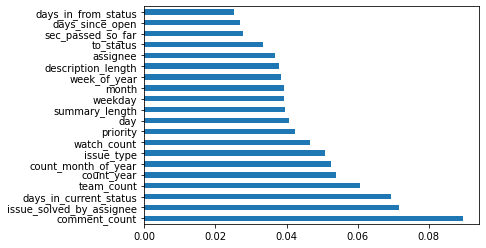

In [195]:

from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
model = ExtraTreesRegressor()
model.fit(X_train,y_train)


#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [235]:
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
# generate dataset
# define feature selection
fs = SelectKBest(score_func=f_regression, k=20)
# apply feature selection
fit = fs.fit(X_train,y_train)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))  #print 10 best features

                       Specs      Score
24                team_count  73.476053
7                watch_count  51.406375
9     days_in_current_status  33.172681
4              comment_count  30.594773
21                     count  27.401547
20  issue_solved_by_assignee  26.081842
2                 vote_count  22.807675
1                 issue_type  15.837309
22       count_month_of_year  14.683087
19       transictions_so_far  14.509814
23                count_year  11.459859
10               from_status   6.896731
5         description_length   6.550083
18         sec_passed_so_far   6.153260
13           days_since_open   6.153260
8                 resolution   5.609584
12                 to_status   5.068656
0                   priority   1.746618
11       days_in_from_status   1.469635
17                     month   0.642753


D:\anaconda\envs\myenv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Index(['team_count', 'days_in_current_status', 'issue_type',
       'count_month_of_year', 'transictions_so_far', 'count_year',
       'comment_count', 'count', 'issue_solved_by_assignee', 'vote_count'],
      dtype='object')
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total= 

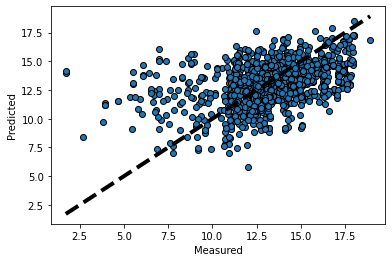

2.4678113872596823

In [378]:
columns = ['team_count','days_in_current_status','issue_type' ,\
       'count_month_of_year','transictions_so_far','count_year','watch_count']

columns2 = ['team_count','days_in_current_status','issue_type' ,\
       'count_month_of_year','transictions_so_far','count_year','comment_count','count','issue_solved_by_assignee'\
        ,'vote_count' ]

run_model(columns2,X_train,y_train)

In [55]:
custom_df

,status,priority,updated,issue_type,reporter,created,resolutiondate,vote_count,project,assignee,...,sec_to_sol,sec_passed_so_far,logsec_to_sol,transictions_so_far,issue_solved_by_assignee,calendar_day,count,count_month_of_year,count_year,team_count
0,1,2,2018-02-22T00:52:52.033+0000,1,elmendavies,2018-02-12T16:12:41.548+0000,2018-02-22T00:52:52.017+0000,0,AVRO,2,...,8.088105e+05,0.000,13.603320,0.0,6,12-2-2018,529,1011,1644,2.0
1,1,2,2018-02-22T00:52:52.033+0000,1,elmendavies,2018-02-12T16:12:41.548+0000,2018-02-22T00:52:52.017+0000,0,AVRO,2,...,7.103487e+05,98461.746,13.473511,1.0,6,13-2-2018,104,1011,1644,2.0
2,1,2,2018-02-23T00:10:37.233+0000,1,kdrakon,2018-01-18T02:49:13.924+0000,2018-02-22T19:26:30.813+0000,0,AVRO,2,...,3.083837e+06,0.000,14.941685,0.0,6,18-1-2018,523,523,1644,2.0
3,1,2,2018-02-27T22:06:15.650+0000,0,radai,2017-05-17T01:27:34.188+0000,2018-02-27T22:06:15.627+0000,0,AVRO,2,...,2.478472e+07,0.000,17.025738,0.0,6,17-5-2017,484,484,4030,2.0
4,1,2,2018-02-27T22:06:15.650+0000,0,radai,2017-05-17T01:27:34.188+0000,2018-02-27T22:06:15.627+0000,0,AVRO,2,...,2.161830e+07,3166420.554,16.889051,1.0,6,22-6-2017,101,807,4030,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122,0,2,2010-09-08T21:07:43.829+0000,0,neopallium,2010-04-03T13:45:43.028+0000,2010-08-25T19:24:00.389+0000,0,AVRO,11,...,1.236892e+07,92979.944,16.330697,1.0,1,4-4-2010,0,1097,18730,3.0
1123,0,2,2010-09-08T21:07:43.829+0000,0,neopallium,2010-04-03T13:45:43.028+0000,2010-08-25T19:24:00.389+0000,0,AVRO,11,...,1.236892e+07,92979.944,16.330697,1.0,1,4-4-2010,2,1097,18730,3.0
1124,0,2,2010-09-08T21:07:43.829+0000,0,neopallium,2010-04-03T13:45:43.028+0000,2010-08-25T19:24:00.389+0000,0,AVRO,11,...,1.236803e+07,93869.582,16.330625,2.0,1,4-4-2010,7,1097,18730,3.0
1125,0,2,2010-09-08T21:07:43.829+0000,0,neopallium,2010-04-03T13:45:43.028+0000,2010-08-25T19:24:00.389+0000,0,AVRO,11,...,1.236803e+07,93869.582,16.330625,2.0,1,4-4-2010,0,1097,18730,3.0


In [291]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


X = X_train[columns]
preprocessed_X_train = StandardScaler().fit_transform(X)


for column in columns:
    print(f"""{column}, {variance_inflation_factor(
                                preprocessed_X_train, 
                                list(columns).index(column))}""")
    
# variance_inflation_factor measures the ratio between the overall model variance with 
#the  single independent variable's variance. Therefore, the higher the value for a specific features, the higlhy collinear 
#the latter is with the target variable

team_count, 1.2262017303084367
days_in_current_status, 1.0705646050904374
issue_type, 1.0098934710774699
count_month_of_year, 1.5756533394150978
transictions_so_far, 1.180960255902547
count_year, 1.5330396336409748


In [292]:
import statsmodels.api as sm



def check_multi_collinearity(columns_to_keep,X_train):
    X = X_train[columns]
    preprocessed_X_train = StandardScaler().fit_transform(X)
    preprocessed_X_train = sm.add_constant(preprocessed_X_train)

    results = sm.OLS(y_train, preprocessed_X_train).fit()
    return results.summary()
check_multi_collinearity(columns,X_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          logsec_to_sol   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     41.98
Date:                Sat, 11 Sep 2021   Prob (F-statistic):           2.51e-46
Time:                        14:48:43   Log-Likelihood:                -2559.7
No. Observations:                1127   AIC:                             5133.
Df Residuals:                    1120   BIC:                             5169.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0465      0.070    186.191      0.000      12.909      13.184
x1             0.7096      0.078      9.145      0.000       0.557       0.862
x2            -0.4469      0.073     -6.164      0.000      -0.589      -0.305
x3             0.3428      0.070      4.868      0.000       0.205       0.481
x4            -0.5440      0.088     -6.185      0.000      -0.717      -0.371
x5            -0.6224      0.076     -8.174      0.000      -0.772      -0.473
x6             0.5257      0.087      6.059      0.000       0.355       0.696
==============================================================================
Omnibus:                      215.025   Durbin-Watson:                   1.134
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              499.364
Skew:                          -1.041   Prob(JB):                    3.67e-109
Kurtosis:                       5.509   Cond. No.                         2.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [293]:
X_train[columns].corr()

,team_count,days_in_current_status,issue_type,count_month_of_year,transictions_so_far,count_year
team_count,1.000000,-0.205098,-0.047829,-0.179740,0.358218,-0.032442
days_in_current_status,-0.205098,1.000000,0.036422,-0.009725,-0.204960,0.014884
issue_type,-0.047829,0.036422,1.000000,0.077199,-0.023850,0.076814
count_month_of_year,-0.179740,-0.009725,0.077199,1.000000,-0.067556,0.578556
transictions_so_far,0.358218,-0.204960,-0.023850,-0.067556,1.000000,-0.085189
count_year,-0.032442,0.014884,0.076814,0.578556,-0.085189,1.000000


In [819]:
columns_to_keep = col_names.to_list()
columns_to_keep.remove('week_of_year')

In [818]:
col_names

Index(['priority', 'issue_type', 'vote_count', 'assignee', 'comment_count',
       'description_length', 'summary_length', 'watch_count', 'resolution',
       'days_in_current_status', 'from_status', 'days_in_from_status',
       'to_status', 'days_since_open', 'weekday', 'week_of_year', 'day',
       'month', 'sec_passed_so_far', 'transictions_so_far',
       'issue_solved_by_assignee', 'count', 'count_month_of_year',
       'count_year', 'team_count'],
      dtype='object')

In [627]:
columns_to_keep.remove('to_status')

In [822]:
run_model(columns_to_keep)
#the mean squared error is used because I want to penalize even the smallest error. Why this? Because the target \
#has been log-transformed and even a small value can lead ti bigger errors later when we will revert the log transform

#rmse can also be used since it highly penalize large errors

KeyError: "None of [Index(['week_of_year'], dtype='object')] are in the [columns]"

In [631]:
check_multi_collinearity(columns_to_keep)

#the R squared tells us the dependet variables logsec_to_sol is still highly explained by the train features


#remember: the p value test the null hypothesis for assessing whether a feature is correlated with the dependent variable.
# if the p value is lower than the confidence threshold (which is is usually 0.05) we cannot reject the null hypothesis which 
#means the feature is actually correlated with the target and we should remove it

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          logsec_to_sol   R-squared (uncentered):                   0.961
Model:                            OLS   Adj. R-squared (uncentered):              0.961
Method:                 Least Squares   F-statistic:                              1237.
Date:                Thu, 09 Sep 2021   Prob (F-statistic):                        0.00
Time:                        22:26:27   Log-Likelihood:                         -2399.5
No. Observations:                1014   AIC:                                      4839.
Df Residuals:                     994   BIC:                                      4937.
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
priority                     1.0080      0.117      8.594      0.000       0.778       1.238
issue_type                   0.4127      0.086      4.819      0.000       0.245       0.581
vote_count                  -0.4842      0.171     -2.837      0.005      -0.819      -0.149
assignee                     0.0903      0.017      5.321      0.000       0.057       0.124
comment_count                0.0171      0.013      1.307      0.192      -0.009       0.043
description_length           0.0001      0.000      0.813      0.417      -0.000       0.000
summary_length               0.0166      0.004      4.286      0.000       0.009       0.024
watch_count                  0.2634      0.045      5.791      0.000       0.174       0.353
from_status                  0.7231      0.332      2.178      0.030       0.072       1.375
days_in_from_status          0.0068      0.003      2.385      0.017       0.001       0.012
days_since_open             -0.0111      0.003     -4.327      0.000      -0.016      -0.006
weekday                      0.2352      0.047      4.972      0.000       0.142       0.328
day                          0.0583      0.009      6.383      0.000       0.040       0.076
month                        0.1450      0.023      6.346      0.000       0.100       0.190
transictions_so_far         -0.6188      0.264     -2.348      0.019      -1.136      -0.102
issue_solved_by_assignee     0.5286      0.047     11.256      0.000       0.436       0.621
count                        0.0043      0.001      4.654      0.000       0.003       0.006
count_month_of_year         -0.0004   7.07e-05     -6.096      0.000      -0.001      -0.000
count_year                   0.0002   1.59e-05     10.101      0.000       0.000       0.000
team_count                   1.1171      0.170      6.584      0.000       0.784       1.450
==============================================================================
Omnibus:                       44.788   Durbin-Watson:                   1.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.935
Skew:                          -0.378   Prob(JB):                     1.77e-15
Kurtosis:                       4.018   Cond. No.                     7.27e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 7.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [592]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
model = LinearRegression()
# initialize RFE
rfe = RFE(
 estimator=model,
 n_features_to_select=3
)
# fit RFE
rfe.fit(X_train, y_train)
# get the transformed data with
# selected columns
X_transformed = rfe.transform(X_train)

In [593]:
X_transformed

array([[0., 0., 2.],
       [1., 1., 2.],
       [0., 0., 2.],
       ...,
       [2., 2., 3.],
       [2., 2., 3.],
       [2., 2., 3.]])

In [103]:
custom_df.to_csv(r'./finaldf.csv',index=False)

In [104]:
custom_df


,status,priority,updated,issue_type,reporter,created,resolutiondate,vote_count,project,assignee,...,sec_to_sol,sec_passed_so_far,logsec_to_sol,transictions_so_far,issue_solved_by_assignee,calendar_day,count,count_month_of_year,count_year,team_count
0,Resolved,Major,2018-02-22T00:52:52.033+0000,Improvement,elmendavies,2018-02-12T16:12:41.548+0000,2018-02-22T00:52:52.017+0000,0,AVRO,cutting,...,8.088105e+05,0.000,13.603320,0.0,6,12-2-2018,529,1011,1644,2.0
1,Resolved,Major,2018-02-22T00:52:52.033+0000,Improvement,elmendavies,2018-02-12T16:12:41.548+0000,2018-02-22T00:52:52.017+0000,0,AVRO,cutting,...,7.103487e+05,98461.746,13.473511,1.0,6,13-2-2018,104,1011,1644,2.0
2,Resolved,Major,2018-02-23T00:10:37.233+0000,Improvement,kdrakon,2018-01-18T02:49:13.924+0000,2018-02-22T19:26:30.813+0000,0,AVRO,cutting,...,3.083837e+06,0.000,14.941685,0.0,6,18-1-2018,523,523,1644,2.0
3,Resolved,Major,2018-02-27T22:06:15.650+0000,Bug,radai,2017-05-17T01:27:34.188+0000,2018-02-27T22:06:15.627+0000,0,AVRO,cutting,...,2.478472e+07,0.000,17.025738,0.0,6,17-5-2017,484,484,4030,2.0
4,Resolved,Major,2018-02-27T22:06:15.650+0000,Bug,radai,2017-05-17T01:27:34.188+0000,2018-02-27T22:06:15.627+0000,0,AVRO,cutting,...,2.161830e+07,3166420.554,16.889051,1.0,6,22-6-2017,101,807,4030,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122,Closed,Major,2010-09-08T21:07:43.829+0000,Bug,neopallium,2010-04-03T13:45:43.028+0000,2010-08-25T19:24:00.389+0000,0,AVRO,neopallium,...,1.236892e+07,92979.944,16.330697,1.0,1,4-4-2010,0,1097,18730,3.0
1123,Closed,Major,2010-09-08T21:07:43.829+0000,Bug,neopallium,2010-04-03T13:45:43.028+0000,2010-08-25T19:24:00.389+0000,0,AVRO,neopallium,...,1.236892e+07,92979.944,16.330697,1.0,1,4-4-2010,2,1097,18730,3.0
1124,Closed,Major,2010-09-08T21:07:43.829+0000,Bug,neopallium,2010-04-03T13:45:43.028+0000,2010-08-25T19:24:00.389+0000,0,AVRO,neopallium,...,1.236803e+07,93869.582,16.330625,2.0,1,4-4-2010,7,1097,18730,3.0
1125,Closed,Major,2010-09-08T21:07:43.829+0000,Bug,neopallium,2010-04-03T13:45:43.028+0000,2010-08-25T19:24:00.389+0000,0,AVRO,neopallium,...,1.236803e+07,93869.582,16.330625,2.0,1,4-4-2010,0,1097,18730,3.0


In [ ]:


#to do: import the last csv containing the count of statuses for each day
#how? for each row, check its status and add new column to keep track of how statuses 
#of the same type were present on the same day 


In [ ]:
#let s give a look to the correlation between pairs of features
fts = ["description_length","summary_length","issue_type","priority", "watch_count", "comment_count", \
      "vote_count", "from_status"]
sns.pairplot(custom_df[fts], size = 2.5)
plt.show();

#I don't see any correlation

In [ ]:
#check for normality distribution
fig = plt.figure()
res = stats.probplot(custom_df['logsec_to_sol'], plot=plt)

In [824]:
custom_df

,status,priority,updated,issue_type,reporter,created,resolutiondate,vote_count,project,assignee,...,sec_to_sol,sec_passed_so_far,logsec_to_sol,transictions_so_far,issue_solved_by_assignee,calendar_day,count,count_month_of_year,count_year,team_count
0,1,2,2018-02-22T00:52:52.033+0000,1,elmendavies,2018-02-12T16:12:41.548+0000,2018-02-22T00:52:52.017+0000,0,AVRO,2,...,8.088105e+05,0.000,13.603320,0.0,6,12-2-2018,529,1011,1644,2.0
1,1,2,2018-02-22T00:52:52.033+0000,1,elmendavies,2018-02-12T16:12:41.548+0000,2018-02-22T00:52:52.017+0000,0,AVRO,2,...,7.103487e+05,98461.746,13.473511,1.0,6,13-2-2018,104,1011,1644,2.0
2,1,2,2018-02-23T00:10:37.233+0000,1,kdrakon,2018-01-18T02:49:13.924+0000,2018-02-22T19:26:30.813+0000,0,AVRO,2,...,3.083837e+06,0.000,14.941685,0.0,6,18-1-2018,523,523,1644,2.0
3,1,2,2018-02-27T22:06:15.650+0000,0,radai,2017-05-17T01:27:34.188+0000,2018-02-27T22:06:15.627+0000,0,AVRO,2,...,2.478472e+07,0.000,17.025738,0.0,6,17-5-2017,484,484,4030,2.0
4,1,2,2018-02-27T22:06:15.650+0000,0,radai,2017-05-17T01:27:34.188+0000,2018-02-27T22:06:15.627+0000,0,AVRO,2,...,2.161830e+07,3166420.554,16.889051,1.0,6,22-6-2017,101,807,4030,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122,0,2,2010-09-08T21:07:43.829+0000,0,neopallium,2010-04-03T13:45:43.028+0000,2010-08-25T19:24:00.389+0000,0,AVRO,11,...,1.236892e+07,92979.944,16.330697,1.0,1,4-4-2010,0,1097,18730,3.0
1123,0,2,2010-09-08T21:07:43.829+0000,0,neopallium,2010-04-03T13:45:43.028+0000,2010-08-25T19:24:00.389+0000,0,AVRO,11,...,1.236892e+07,92979.944,16.330697,1.0,1,4-4-2010,2,1097,18730,3.0
1124,0,2,2010-09-08T21:07:43.829+0000,0,neopallium,2010-04-03T13:45:43.028+0000,2010-08-25T19:24:00.389+0000,0,AVRO,11,...,1.236803e+07,93869.582,16.330625,2.0,1,4-4-2010,7,1097,18730,3.0
1125,0,2,2010-09-08T21:07:43.829+0000,0,neopallium,2010-04-03T13:45:43.028+0000,2010-08-25T19:24:00.389+0000,0,AVRO,11,...,1.236803e+07,93869.582,16.330625,2.0,1,4-4-2010,0,1097,18730,3.0


In [ ]:
df_day_count.head()

In [ ]:
# Since all the sovled issue are closed or 

In [ ]:
df_day_count.head()
sns.catplot(x="status", y="count", kind="box", data=df_day_count)

In [ ]:
custom_df["status"].value_counts()

In [ ]:
tempd = df[df["resolutiondate"].isna()]
tempd = df[df["status"] == "Solved"]
tempd

In [ ]:
#I have a doubt whether there are issuse with not null resolutiodate and issue type different from [closed,solved]
m = df_transition[df_transition["resolutiondate"].notnull()]
len(m["key"].unique())
a = m

In [ ]:
m2 = df[df["resolutiondate"].notnull()]
len(m2["key"].unique())
b = m2

In [ ]:
merge = a.merge(b,how="inner",on="key")
len(merge["key"].unique())

In [ ]:
m = df_transition[df_transition["resolutiondate"].notnull()]
m["status"].unique()


kryzthov
2013-04-17T05:24:30.698+0000
Open
Patch Available
cutting
2013-04-23T17:11:53.429+0000
Patch Available
Resolved
{'key': ['AVRO-1299', 'AVRO-1299'], 'when': ['2013-04-17T05:24:30.698+0000', '2013-04-23T17:11:53.429+0000'], 'from_status': ['Open', 'Patch Available'], 'to_status': ['Patch Available', 'Resolved'], 'who': ['kryzthov', 'cutting'], 'days_since_open': [0, 6]}


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   key              2 non-null      object
 1   when             2 non-null      object
 2   from_status      2 non-null      object
 3   to_status        2 non-null      object
 4   who              2 non-null      object
 5   days_since_open  2 non-null      int64 
 6   assignee         2 non-null      object
 7   comment_count    2 non-null      int64 
 8   created          2 non-null      object
 9   issue_type       2 non-null      object
 10  priority         2 non-null      object
 11  vote_count       2 non-null      int64 
 12  watch_count      2 non-null      int64 
 13  resolutiondate   2 non-null      object
 14  summary_length   2 non-null      int64 
 15  updated          2 non-null      int64 
dtypes: int64(6), object(10)
memory usage: 272.0+ bytes


In [62]:
custom_df

,status,priority,updated,issue_type,reporter,created,resolutiondate,vote_count,project,assignee,...,to_status,days_since_open,transition,weekday,week_of_year,day,month,year,sec_to_sol,sec_passed_so_far
0,Resolved,Major,2018-04-24T06:34:58.782+0000,Improvement,jmukesh,2018-04-06T13:45:28.721+0000,2018-04-24T06:34:58.762+0000,0,AVRO,NaN,...,Open,NaN,Non-existent to Open,4.0,14.0,6.0,4.0,2018.0,1529370.041,0.000
2,Resolved,Major,2018-04-24T06:34:37.360+0000,Bug,jmukesh,2018-04-05T13:21:01.183+0000,2018-04-24T06:34:37.339+0000,0,AVRO,NaN,...,Open,NaN,Non-existent to Open,3.0,14.0,5.0,4.0,2018.0,1617216.156,0.000
4,Resolved,Major,2018-04-24T06:34:15.849+0000,Bug,jmukesh,2018-04-04T16:39:43.364+0000,2018-04-24T06:34:15.829+0000,0,AVRO,NaN,...,Open,NaN,Non-existent to Open,2.0,14.0,4.0,4.0,2018.0,1691672.465,0.000
6,Resolved,Major,2018-04-24T06:32:37.556+0000,Bug,jmukesh,2018-04-04T16:29:37.306+0000,2018-04-24T06:32:37.535+0000,0,AVRO,NaN,...,Open,NaN,Non-existent to Open,2.0,14.0,4.0,4.0,2018.0,1692180.229,0.000
8,Resolved,Trivial,2018-03-14T16:45:08.597+0000,Bug,maxenglander,2018-03-09T06:18:47.199+0000,2018-03-14T16:45:08.577+0000,0,AVRO,maxenglander,...,Open,NaN,Non-existent to Open,4.0,10.0,9.0,3.0,2018.0,469581.378,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5403,Closed,Major,2009-07-14T22:50:08.061+0000,Improvement,cutting,2009-04-09T22:34:55.599+0000,2009-06-02T19:04:10.508+0000,0,AVRO,cutting,...,In Progress,47.827881,Open to In Progress,2.0,22.0,27.0,5.0,2009.0,520625.979,4132328.930
5404,Closed,Major,2009-07-14T22:50:08.061+0000,Improvement,cutting,2009-04-09T22:34:55.599+0000,2009-06-02T19:04:10.508+0000,0,AVRO,cutting,...,Patch Available,49.970872,In Progress to Patch Available,4.0,22.0,29.0,5.0,2009.0,335471.528,4317483.381
5407,Closed,Major,2009-07-14T22:50:07.862+0000,Bug,cutting,2009-04-09T22:09:08.216+0000,2009-04-27T20:14:06.572+0000,0,AVRO,cutting,...,Open,NaN,Non-existent to Open,3.0,15.0,9.0,4.0,2009.0,1548298.356,0.000
5408,Closed,Major,2009-07-14T22:50:07.862+0000,Bug,cutting,2009-04-09T22:09:08.216+0000,2009-04-27T20:14:06.572+0000,0,AVRO,cutting,...,In Progress,12.820786,Open to In Progress,2.0,17.0,22.0,4.0,2009.0,440582.463,1107715.893


In [925]:
custom_df[custom_df['key']['AVRO-1299']

SyntaxError: unexpected EOF while parsing (<ipython-input-925-b186c0e2ef37>, line 1)

custom_df

In [41]:
custom_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2661 entries, 0 to 5409
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   status                  2661 non-null   object 
 1   priority                2661 non-null   object 
 2   updated                 2661 non-null   object 
 3   issue_type              2661 non-null   object 
 4   reporter                2661 non-null   object 
 5   created                 2661 non-null   object 
 6   resolutiondate          2661 non-null   object 
 7   vote_count              2661 non-null   int64  
 8   project                 2661 non-null   object 
 9   assignee                2341 non-null   object 
 10  comment_count           2661 non-null   int64  
 11  key                     2661 non-null   object 
 12  description_length      2543 non-null   float64
 13  summary_length          2661 non-null   int64  
 14  watch_count             2661 non-null   

In [299]:
from hyperopt import hp

ModuleNotFoundError: No module named 'hyperopt'

In [300]:
!pip install hyperopt

  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)
  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.9
    Uninstalling decorator-5.0.9:
      Successfully uninstalled decorator-5.0.9


In [ ]:
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.01, 0.05, 0.1)),
    'max_depth':        hp.choice('max_depth',        np.arange(3, 0.05, 25,dtype=int)),
    'gamma':        hp.choice('gamma',        np.arange(0.05, 0.05, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [ ]:
#generate full dataframe with rows whose resolution data column is not none

In [117]:

merged_df = df.merge(df_transition,how="inner",on="key",suffixes=('', '_drop'))
custom_df = merged_df
for index, row in merged_df.iterrows():
    
    t_current = datetime.datetime.strptime(row['when'], "%Y-%m-%dT%H:%M:%S.%f%z")
    #day of week
    custom_df.loc[index,'weekday']  = t_current.weekday()
    custom_df.loc[index,'week_of_year'] = t_current.isocalendar()[1]
    custom_df.loc[index,'day'] = t_current.day
    custom_df.loc[index,'month'] = t_current.month
    custom_df.loc[index,'year'] = t_current.year
    #t_spent_in_month = t_spent_in_hours/30    
    
    if( str(row['resolutiondate']) != 'nan'):
        t_created = datetime.datetime.strptime(row['created'], "%Y-%m-%dT%H:%M:%S.%f%z")
        t_solved = datetime.datetime.strptime(row['resolutiondate'], "%Y-%m-%dT%H:%M:%S.%f%z")
        sol_time_spent = t_solved - t_current
        time_passed_so_far = t_current - t_created

        t_passed_seconds = time_passed_so_far.total_seconds()
        t_spent_in_seconds = sol_time_spent.total_seconds()
        t_spent_in_minutes = t_spent_in_seconds/60    
        t_spent_in_hours = t_spent_in_minutes/60
        t_spent_in_days = t_spent_in_hours/24




        if(t_spent_in_seconds > 0):
            custom_df.loc[index,'sec_to_sol'] = t_spent_in_seconds
        else:
            #I noticed there are transitions in which the creation date is later than the solution date. I want to delete
            #those because it is useless
            custom_df.loc[index,'sec_to_sol'] = np.nan

        if t_passed_seconds > 0:
            custom_df.loc[index,'sec_passed_so_far'] = t_passed_seconds
        else:
            custom_df.loc[index,'sec_passed_so_far'] = 0
custom_df.info()



#for each key of the resolved issues, we keep count of the previous transictions made so far
issue_keys = custom_df["key"].unique()
issue_keys_dict = { key : 0 for key in issue_keys }

# #we sort rows by their time of creation
sorted_df = custom_df.sort_values(by=['when'])
for index, row in sorted_df.iterrows():
    #we create new feature
    custom_df.loc[index,'transictions_so_far'] = issue_keys_dict[row['key']]
    #we keep count of the # of transictions so far
    issue_keys_dict[row['key']] += 1
    
    
custom_df.loc[custom_df['from_status'].isna(),['from_status']] = 'Inexistent'
custom_df.loc[custom_df['days_since_open'].isna(),['days_since_open']] = 0
custom_df.loc[custom_df['days_in_from_status'].isna(),['days_in_from_status']] = 0
custom_df.loc[custom_df['description_length'].isna(),['description_length']] = custom_df['description_length'].mean()


#feature to capture how many issues the assigned user solved so far 
problem_solvers = custom_df[custom_df['to_status'] == 'Resolved']['assignee'].value_counts().reset_index()
problem_solvers= problem_solvers.rename(columns={"index": 'assignee', 'assignee': "issue_solved_by_assignee"})
custom_df = pd.merge(custom_df, problem_solvers,  on=['assignee'])


to_modify = ['Patch Available', 'Resolved','In Progress','Reopened']
custom_df.loc[custom_df['from_status'].isin(to_modify),['from_status'] ] = 'RARE'


to_modify = ['Resolved','In Progress','Reopened']
custom_df.loc[custom_df['to_status'].isin(to_modify),['to_status'] ] = 'RARE'
df_day_count.loc[df_day_count['status'].isin(to_modify),['status'] ] = 'RARE'


def get_calender_day(x):
    o = datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%f%z")
    
    return str(o.day) + "-" + str(o.month) + "-" + str(o.year)
    
#I convert both the Iso date into string of the following format (dd-mm-yyyy) in order to 
custom_df['calendar_day'] = custom_df['when'].apply(
        lambda x: get_calender_day(x) )  

df_day_count['calendar_day'] = df_day_count['day'].apply(
        lambda x: get_calender_day(x) )  


#we merge the previous custom df made so far  and the day_count df
custom_df = pd.merge(custom_df, df_day_count,  how='left', left_on=['calendar_day','to_status'], right_on = ['calendar_day','status'],suffixes=('', '_drop'))
#we drop every duplicate from the merge process
custom_df.drop([col for col in custom_df.columns if 'drop' in col], axis=1, inplace=True)


# number of issue of the same per month and year
custom_df['count_month_of_year'] = custom_df.groupby(['year','month'])['count'].transform('sum')
custom_df['count_year'] =  custom_df.groupby(['year'])['count'].transform('sum')


group_assignee = custom_df.groupby(['key'])['assignee'].unique().reset_index()
group_reporter = custom_df.groupby(['key'])['reporter'].unique().reset_index()
group_who = custom_df.groupby(['key'])['who'].unique().reset_index()


merge_groups = pd.merge(group_assignee, group_reporter,  on='key')
merge_groups = pd.merge(merge_groups, group_who,  on='key')

for index, row in merge_groups.iterrows():
    teamList = list(row['assignee'])
    
    for el in row['reporter']:
        if(el not in teamList):
            teamList.append(el)
            
    for el in row['who']:
        if(el not in teamList):
            teamList.append(el)
            
    merge_groups.loc[index,'team_count'] = len(teamList)
    
    
custom_df = pd.merge(custom_df, merge_groups,  on='key' ,suffixes=('', '_drop'))
custom_df.drop([col for col in custom_df.columns if 'drop' in col], axis=1, inplace=True)

custom_df.to_csv(r'./complete_df.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6260 entries, 0 to 6259
Data columns (total 47 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   status                       6260 non-null   object 
 1   priority                     6260 non-null   object 
 2   updated                      6260 non-null   object 
 3   issue_type                   6260 non-null   object 
 4   reporter                     6260 non-null   object 
 5   created                      6260 non-null   object 
 6   resolutiondate               5412 non-null   object 
 7   vote_count                   6260 non-null   int64  
 8   project                      6260 non-null   object 
 9   assignee                     4977 non-null   object 
 10  comment_count                6260 non-null   int64  
 11  key                          6260 non-null   object 
 12  description_length           5974 non-null   float64
 13  summary_length    

In [118]:
custom_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7751 entries, 0 to 7750
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   status                    7751 non-null   object 
 1   priority                  7751 non-null   object 
 2   updated                   7751 non-null   object 
 3   issue_type                7751 non-null   object 
 4   reporter                  7751 non-null   object 
 5   created                   7751 non-null   object 
 6   resolutiondate            7517 non-null   object 
 7   vote_count                7751 non-null   int64  
 8   project                   7751 non-null   object 
 9   assignee                  7751 non-null   object 
 10  comment_count             7751 non-null   int64  
 11  key                       7751 non-null   object 
 12  description_length        7751 non-null   float64
 13  summary_length            7751 non-null   int64  
 14  watch_co